# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Project F: Measuring the Shape and Brightness of Galaxies with Neural Networks
### Milestone 2: Exploratory Data Analysis
### Group 75: Dmitry Vukolov, Ning Xu, Rohit Beri, Sunil Chomal


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>


<hr style="height:2pt">

---



In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML, display

styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

# Outline

1. Overview
2. Loading the Data
3. Structure and Size of the Data
4. Basic Statistics of the Data 
5. Visualization of the Image Data 
6. Distributions of the Labels and Numerical Attributes 
7. Parametric Image Generation
8. Summary

## <div class="theme"> Overview </div> 

<div style="border: 3px solid #800080; padding: 10px"> 
    
### ***Shape and Brightness of a Galaxy***

<br>

**Flux:**
* 


**Sersic Index:**
* 


**Sersic Radius:**
* 


**g1:**
* 


**g2:**
* 


**Elliplicity:**
* 


**Orientation:**
* 


**Signal to Noise Ratio:**
* 


**Noise:**
* 


# Sunil to update? 

### <div class='exercise'> <b> Step 0: Load the essential libraries </b> </div>

In [2]:
# Load useful libraries
import os
import sys
import copy
import math
import time
import random
import numpy as np
import pandas as pd
import ipywidgets as widgets
from sklearn.preprocessing import minmax_scale

# Import h5py for reading h5 files
import h5py

# Load galsim for data generation
import galsim

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tweak plot resolution and styling
%config InlineBackend.figure_format = 'retina'
sns.set(style="white", palette=None, rc={"axes.linewidth": 1})
plt.rc('image', cmap="viridis")

### <div class='exercise'> <b> Step 1: Load the data </b> </div>

In [3]:
# Read the data set
with h5py.File("./data/Data1.h5", "r") as f:
    image = f["img"][:]
    cat = f["cat"][:]
    label = f["label"][:]  # this gives the set of parameters that characterize the galaxy
    psf = f["psf_r"][:]
    snr = f["snr"][:]
    sigma = f["sigma"][:]
    image_nonoise = f["img_nonoise"][:]
    image_withnoise = f["img_withnoise"][:]

    keys = [key for key in list(f.keys())]

print("Keys in Database:")
for key in keys:
    print("          {}".format(key))

Keys in Database:
          cat
          img
          img_nonoise
          img_withnoise
          label
          psf_r
          sigma
          snr


<div style="border: 3px solid #800080; padding: 10px"> 

***Observations:***
* The provided dataset comprises of 8 different tables with the following names and contents:
    - **cat:** Contains a set of generated images and five types of preprocessed images.
    - **img:** Holds the original images of the galaxies produced by `GalSim` with the added noise.
    - **img_nonoise:** This table includes noiseless images generated by `GalSim`.
    - **img_withnoise:** This table contains noisy versions of the images and looks very similar to **img** except for the scale of the pixel values.
    - **label:** Captures the set of parameters that characterize the simulated galaxy.
    - **sigma:** This table records the level of the added noise in each image.
    - **snr:** Lists the signal-to-noise ratio of a given image.
    - **psf_r**: This table likely contains information about the PSF or the point spread function. The PSF gives a measure of the amount of blurring that is added to any given object as a result of imperfections in the optics.

### <div class='exercise'> <b> Step 2: Structure and Size of the Data </b> </div>

In [4]:
# Structure and Size of the Data
print("Image Shape            = {}".format(image.shape))
print("No-noise Image Shape   = {}".format(image_nonoise.shape))
print("With-noise Image Shape = {}".format(image_withnoise.shape))
print("Cat Shape              = {}".format(cat.shape))
print("Label Shape            = {}".format(label.shape))
print("SNR Shape              = {}".format(snr.shape))
print("Sigma Shape            = {}".format(sigma.shape))
print("PSF-R Shape            = {}".format(psf.shape))

Image Shape            = (18779, 64, 64)
No-noise Image Shape   = (18779, 64, 64)
With-noise Image Shape = (18779, 64, 64)
Cat Shape              = (18779, 6, 64, 64)
Label Shape            = (18779, 5)
SNR Shape              = (18779,)
Sigma Shape            = (18779,)
PSF-R Shape            = (20000,)


<div style="border: 3px solid #800080; padding: 10px"> 

***Observations:***
* All of the tables in the database contain $18779$ data points except for the PSF table
* At this stage, since we are unaware of the reasons for this discrepancy, we will ignore the PSF table for EDA
* The Image, Non-noise Image & With-noise Image tables all have $18779$ grayscale images with the resolution of $64 \times 64$ pixels
* The "Cat" table comprises of $18779 \times 6$ images with a $64 \times 64$ resolution ($18779$ images from the Image table and $5$ preprocessed versions for each original image)
* The labels contain information about $5$ different attributes of the galaxy. These attributes are `flux`, `sersic index`, `sersic radius`, `g1` and `g2`
* The Sigma table records the level of noise added to the image and SNR gives the signal-to-noise ratio in the resulting image

### <div class='exercise'> <b> Step 3: Basic Statistics of the Data </b> </div>

In [5]:
# Gather the image and attribute tables for processing
tables = {
    "Image": image,
    "No-noise Image": image_nonoise,
    "With-noise Image": image_withnoise,
    "Cat Image 0": cat[:, 0],
    "Cat Image 1": cat[:, 1],
    "Cat Image 2": cat[:, 2],
    "Cat Image 3": cat[:, 3],
    "Cat Image 4": cat[:, 4],
    "Cat Image 5": cat[:, 5],
    "SNR": snr,
    "Sigma": sigma,
    "PSF-R": psf,
}
# Map each of the five labels to their names
labels = pd.DataFrame(label, columns=["Flux", "Sersic Index", "Sersic Radius", "g1", "g2"])

# Compute basic statistics
stats = {name: [data.mean(), data.var(), data.min(), data.max()] for name, data in tables.items()}
pd.concat(
    [
        pd.DataFrame.from_dict(stats, orient="index", columns=["mean", "var", "min", "max"]),
        labels.agg(["mean", "var", "min", "max"]).T,
    ]
).rename_axis("Data Type").rename(columns=lambda x: x.title()).round(2)

Mean        Var      Min       Max
Data Type                                             
Image               0.14       1.70    -5.47     36.95
No-noise Image     40.74   66796.32    -0.13  13615.28
With-noise Image   40.76  160145.77 -1950.24  14236.50
Cat Image 0         0.14       1.70    -5.47     36.95
Cat Image 1         1.22      70.65     0.00    965.49
Cat Image 2         0.08       0.65    -4.87     12.91
Cat Image 3        14.42   32851.87 -1772.62   3345.63
Cat Image 4         0.02       0.04     0.00      7.64
Cat Image 5         0.04       0.73     0.00     58.40
SNR                49.12     538.43     9.99    100.00
Sigma             299.83    3416.30   200.00    400.00
PSF-R               0.75       0.02     0.50      1.00
Flux                1.70       0.79     0.30      4.10
Sersic Index        3.28       2.50     0.50      6.00
Sersic Radius       0.36       0.02     0.10      0.60
g1                 -0.00       0.08    -0.67      0.67
g2                  0.00       0.08    -0.67      0.67

In [6]:
# Check if the original images and the Cat 0 images are the same
np.array_equal(cat[:, 0], image)

True

<div style="border: 3px solid #800080; padding: 10px"> 
 
***Observations:***
* Mean pixel value of Image data is $0.14$ and lies in the range of $-5.47$ to $36.95$ with a variance of $1.70$
* Cat Image 0 and Image tables are exactly the same
* No-noise Images and With-noise Images are on a different pixel value scale from Image data
* Mean pixel value of No-noise Images and With-noise Images are almost the same - noise likely has a mean of $0$
* Signal-to-noise ratio varies from $10$ to $100$ with a mean of $49$. This corresponds to the suggested range for selecting the images.
* Sigma varies from $200$ to $400$ with a mean of $300$
* PSF-R varies from $0.50$ to $1.00$ with a mean of $0.75$
* Flux varies between $0.30$ and $4.10$ with a mean of $1.70$
* Sersic Index varies between $0.50$ and $6.00$ with a mean of $3.28$
* Sersic Radius varies between $0.10$ and $0.60$ with a mean of $0.36$
* g1 varies between $-0.67$ and $0.67$ with a mean of $0.00$
* g2 varies between $-0.67$ and $0.67$ with a mean of $0.00$

### <div class='exercise'> <b> Step 4: Visualization of the Image Data </b> </div>

<div class='gc'> <b> Select random images for visualization </b> </div>

In [7]:
np.random.seed(42)
idx = np.random.randint(image.shape[0], size=16)
idx = sorted(idx)

<div style="border: 3px solid #800080; padding: 10px"> 

***Comment:***
* We randomly select the following $16$ image ID's for visualization

<div class='gc'> <b> Plot selected image ID's from the Image table </b> </div>

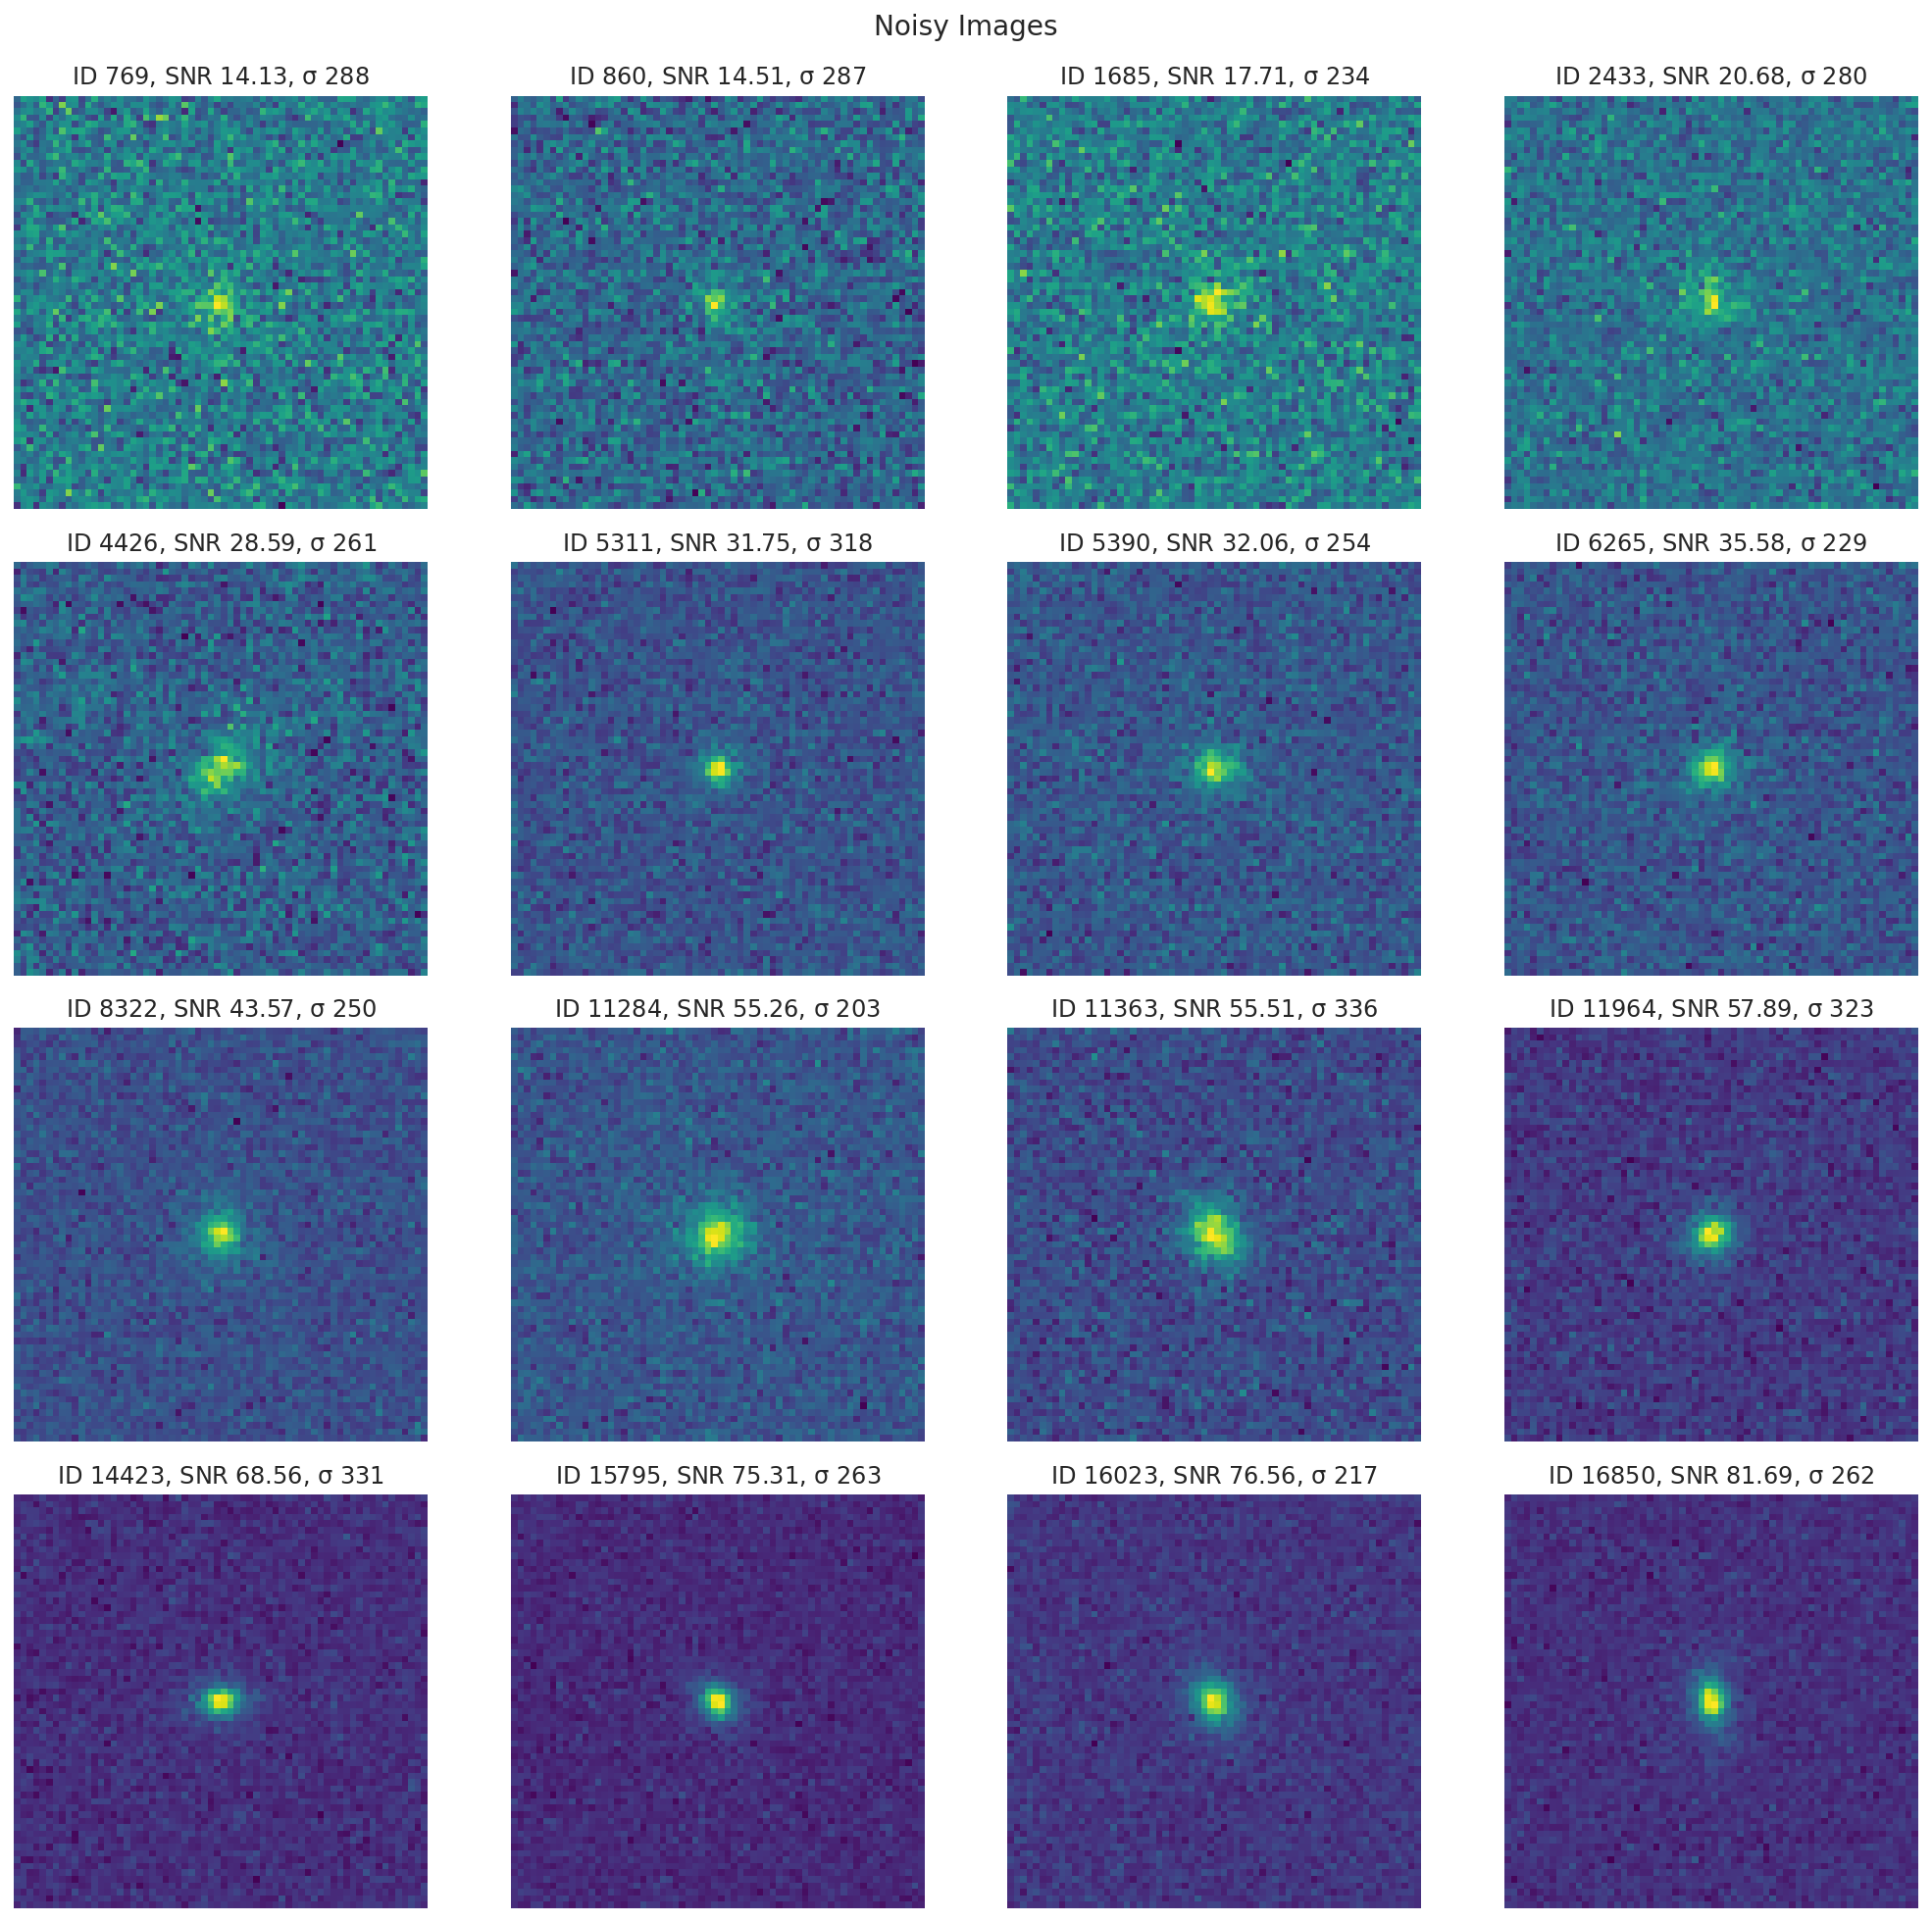

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(14, 13.5), constrained_layout=True)

for i, ax in zip(idx, axes.flat):
    ax.imshow(image[i])
    ax.set_title(f"ID {i}, SNR ${snr[i]:0.2f}$, σ ${sigma[i]:.0f}$")
    ax.axis("off")

fig.suptitle("Noisy Images", fontsize=14);

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* Images have varying degrees of noisiness
* Darker background images have high Signal-to-Noise Ratio
* Darker vs lighter backgrounds are mainly driven by Flux (to be shown later)
* Absolute noisiness given by sigma is less meaningful than relative noisiness measured by SNR
* From these noisy images it is hard to understand the shape and brightness of the galaxy
* One point to note that galaxy is always centered in the image

<div class='gc'> <b> Plot selected image ID's from the No-noise Image table </b> </div>

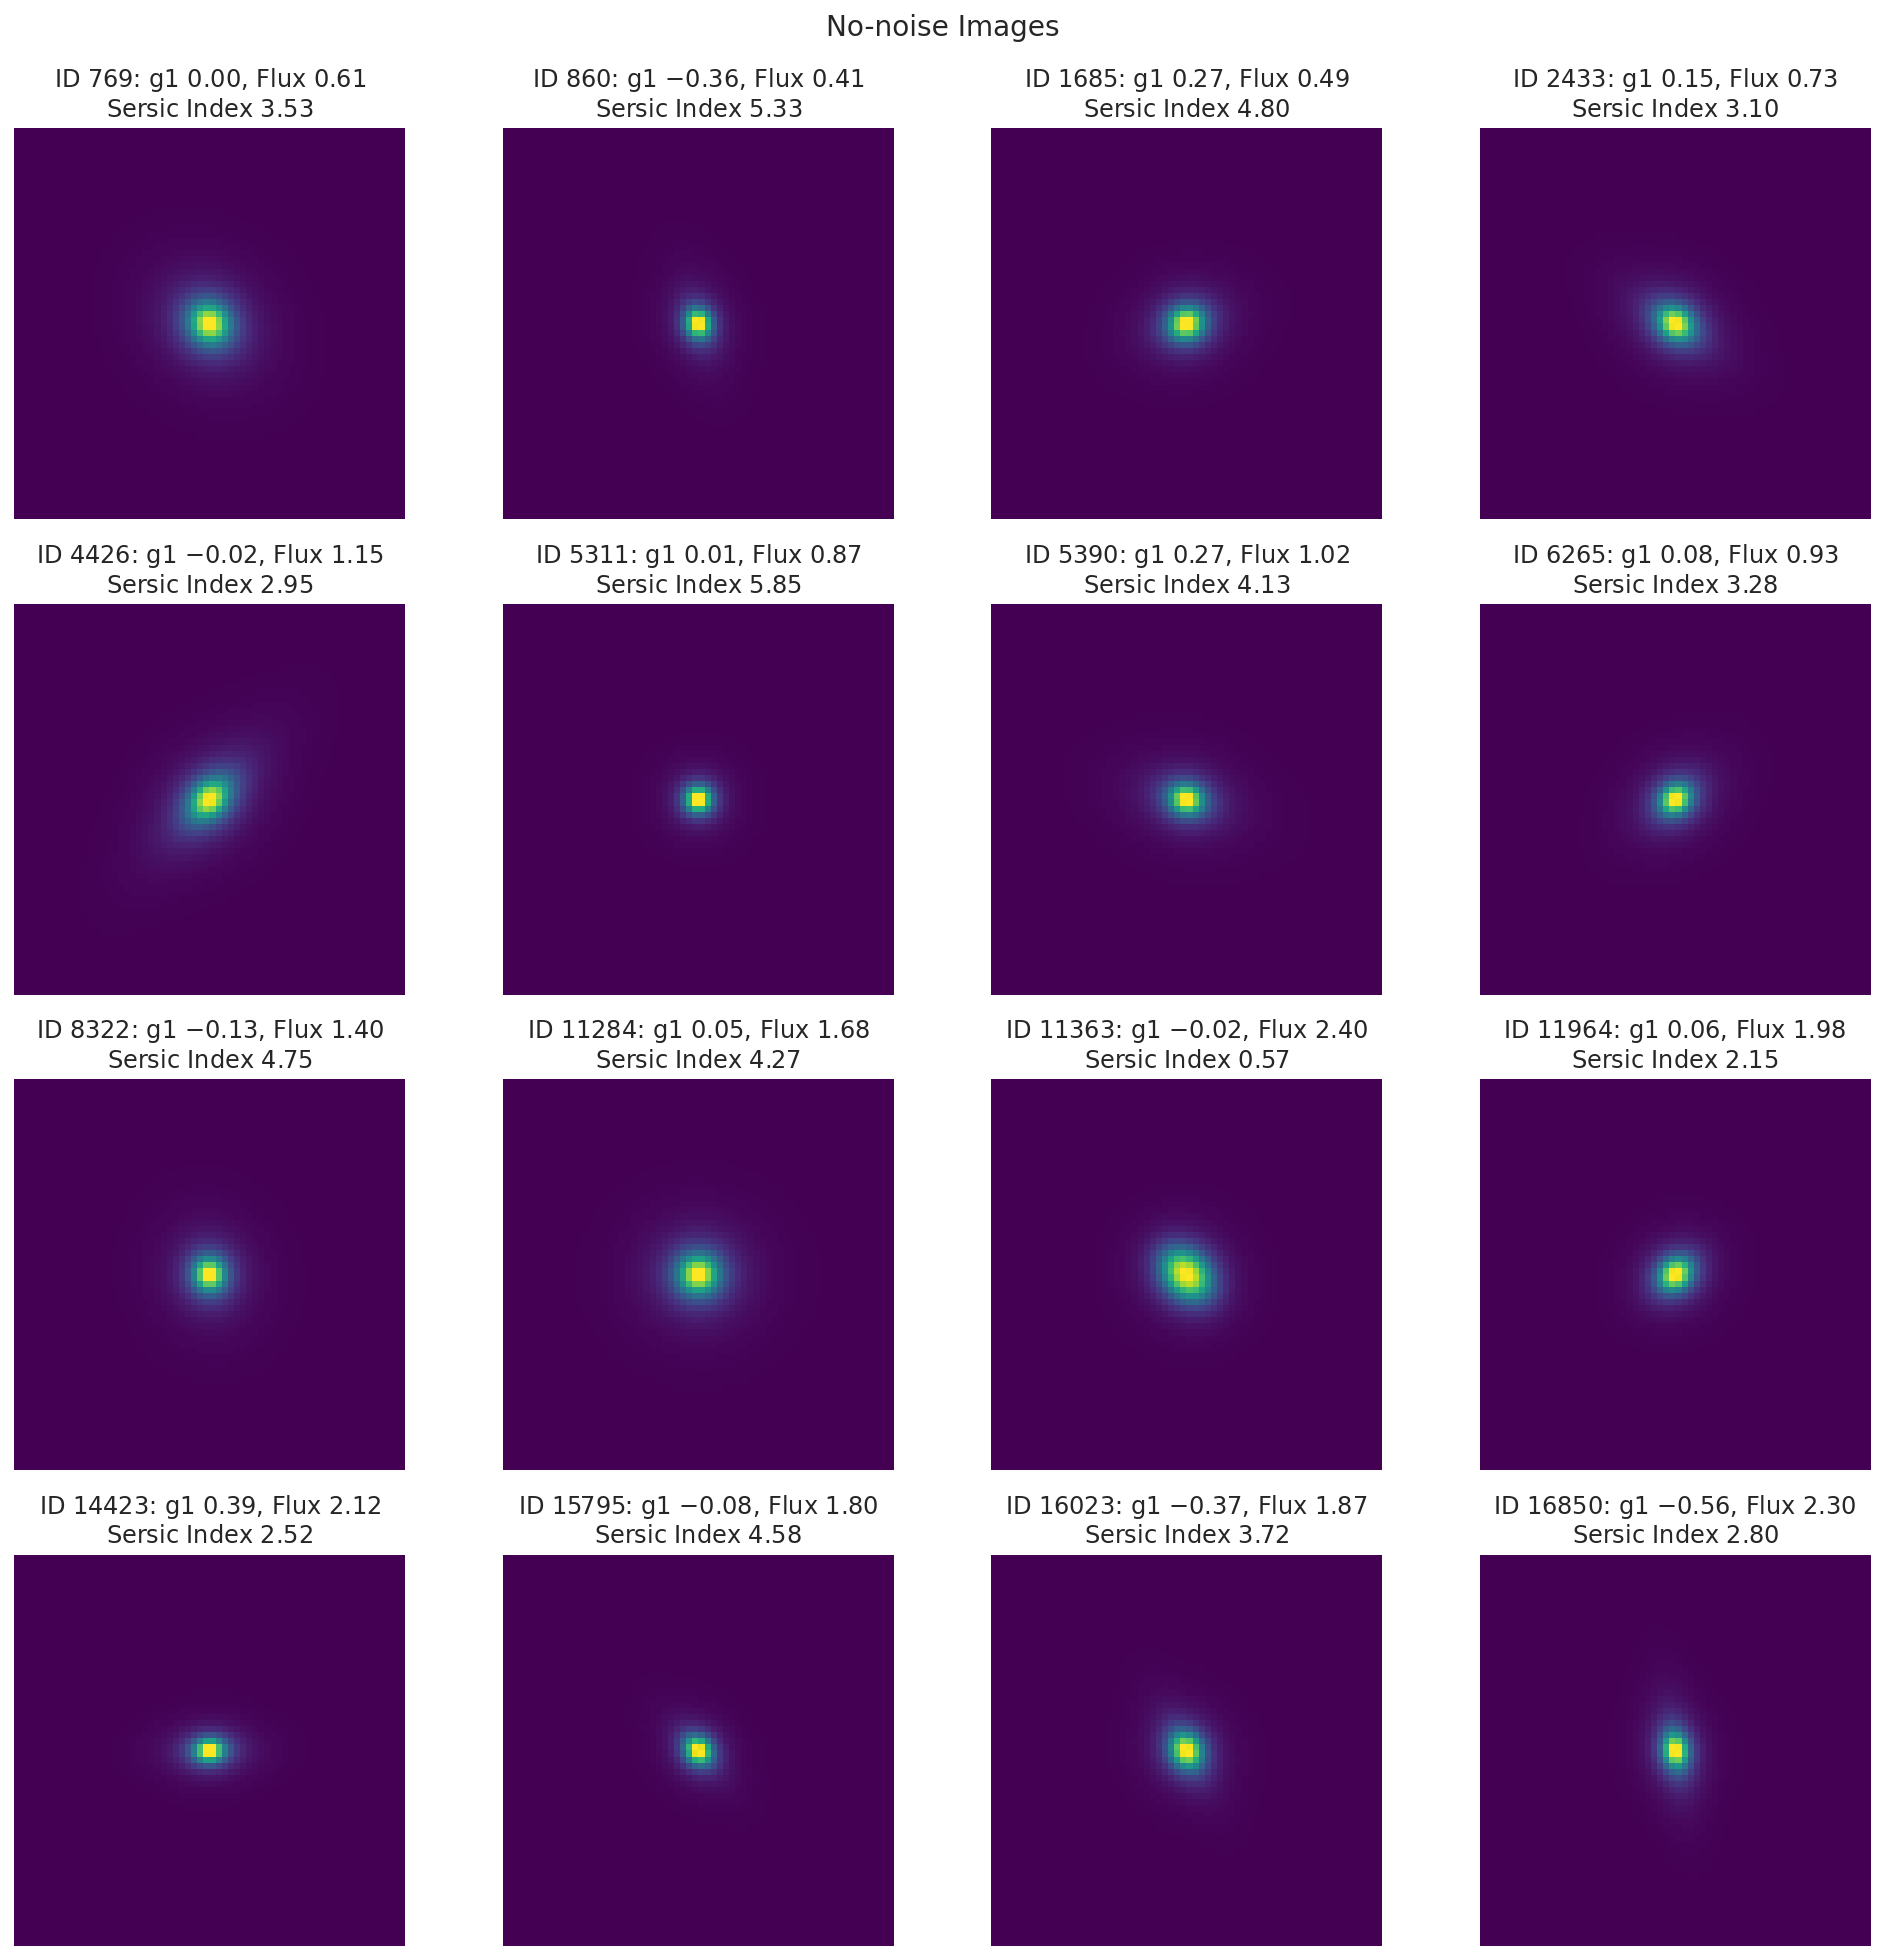

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(13.5, 13.5), constrained_layout=True)

title = """ID {}: g1 ${g1:.2f}$, Flux ${flux:.2f}$
Sersic Index ${sersic_index:.2f}$"""

for i, ax in zip(idx, axes.flat):
    ax.imshow(image_nonoise[i])
    ax.set_title(
        title.format(i, g1=labels.g1[i], flux=labels.Flux[i], sersic_index=labels["Sersic Index"][i])
    )
    ax.axis("off")

fig.suptitle("No-noise Images", fontsize=14);

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* In the noiseless images, we get a better idea about the shape and orientation of the galaxy
* Galaxy in image ID 5311 is likely circular; where one in image ID 11363 is likely elliptical
* Galaxy in image 4426 is oriented perpendicular to the one in image 11363 and the one in image 11423 looked oriented horizontally
* However, it is still difficult to say anything about the brightness by just looking at the image.
    - This might due to the way matplotlib plots the picture i.e. it normalizes individual plot data, which make them incomparable to other plots

<div class='gc'> <b> Show the equivalency of Images and With-noise Images </b> </div>

In [10]:
# Scale all image pixels values to be between 0 and 1
image_scaled = minmax_scale(image.reshape(-1, 64 * 64), axis=1)
withnoise_scaled = minmax_scale(image_withnoise.reshape(-1, 64 * 64), axis=1)

# Test if the results are the same
np.allclose(image_scaled, withnoise_scaled)

True

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* The pictures from the main Image data table and the With-noise Image table are exactly the same after scaling to the range between 0 and 1
* Both image tables carry the same information but are originally recorded in different units

<div class='gc'> <b> Plot 4 selected image ID's from the two tables for comparison </b> </div>

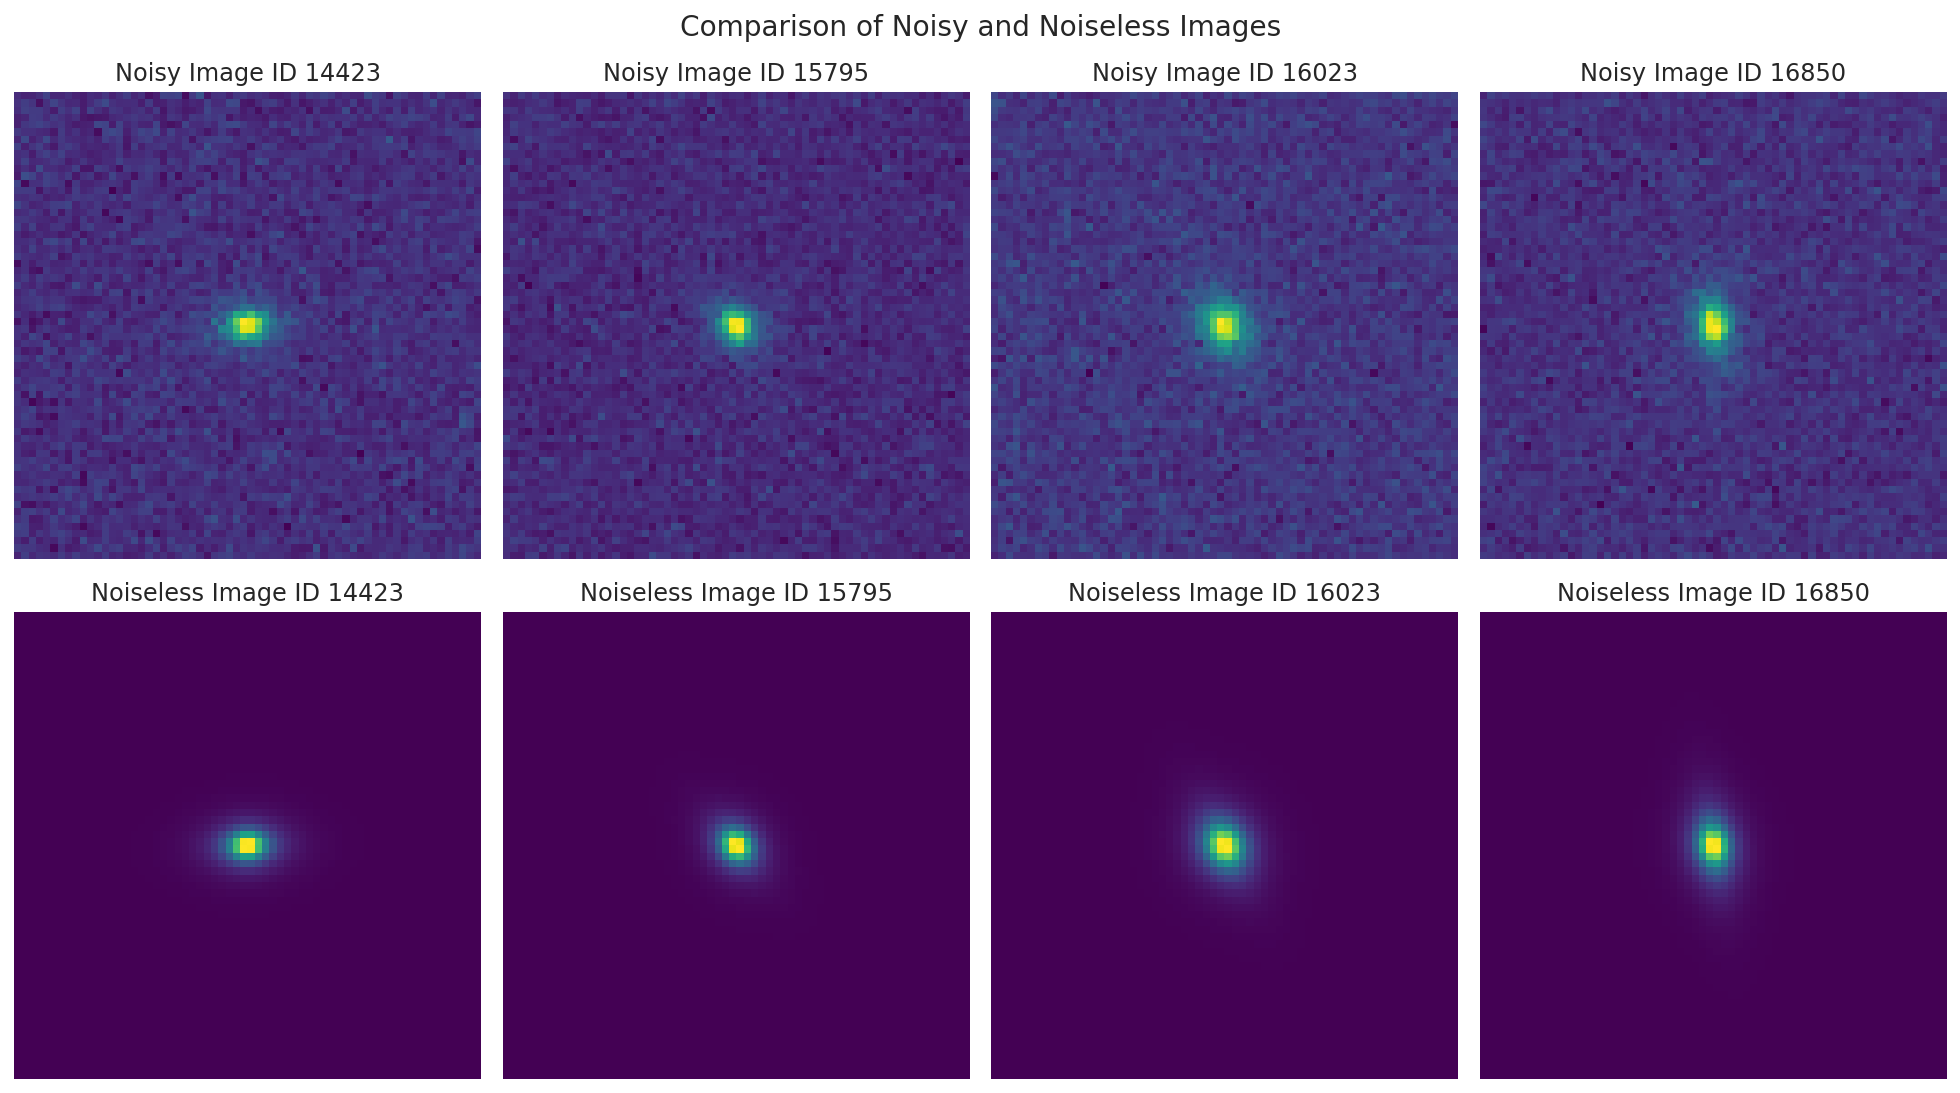

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(13.5, 7.5), constrained_layout=True)
for i, image_id in enumerate(idx[-4:]):
    ax[0, i].imshow(image[image_id])
    ax[0, i].set_title(f"Noisy Image ID {image_id}")
    ax[0, i].axis("off")
    ax[1, i].imshow(image_nonoise[image_id])
    ax[1, i].set_title(f"Noiseless Image ID {image_id}")
    ax[1, i].axis("off")

fig.suptitle("Comparison of Noisy and Noiseless Images", fontsize=14);

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* The Non-noise images correspond reasonably well to the respective noisy images

<div class='gc'> <b> Plot the noise ("With Noise Image" minus "No Noise Image") from selected image ID's </b> </div>

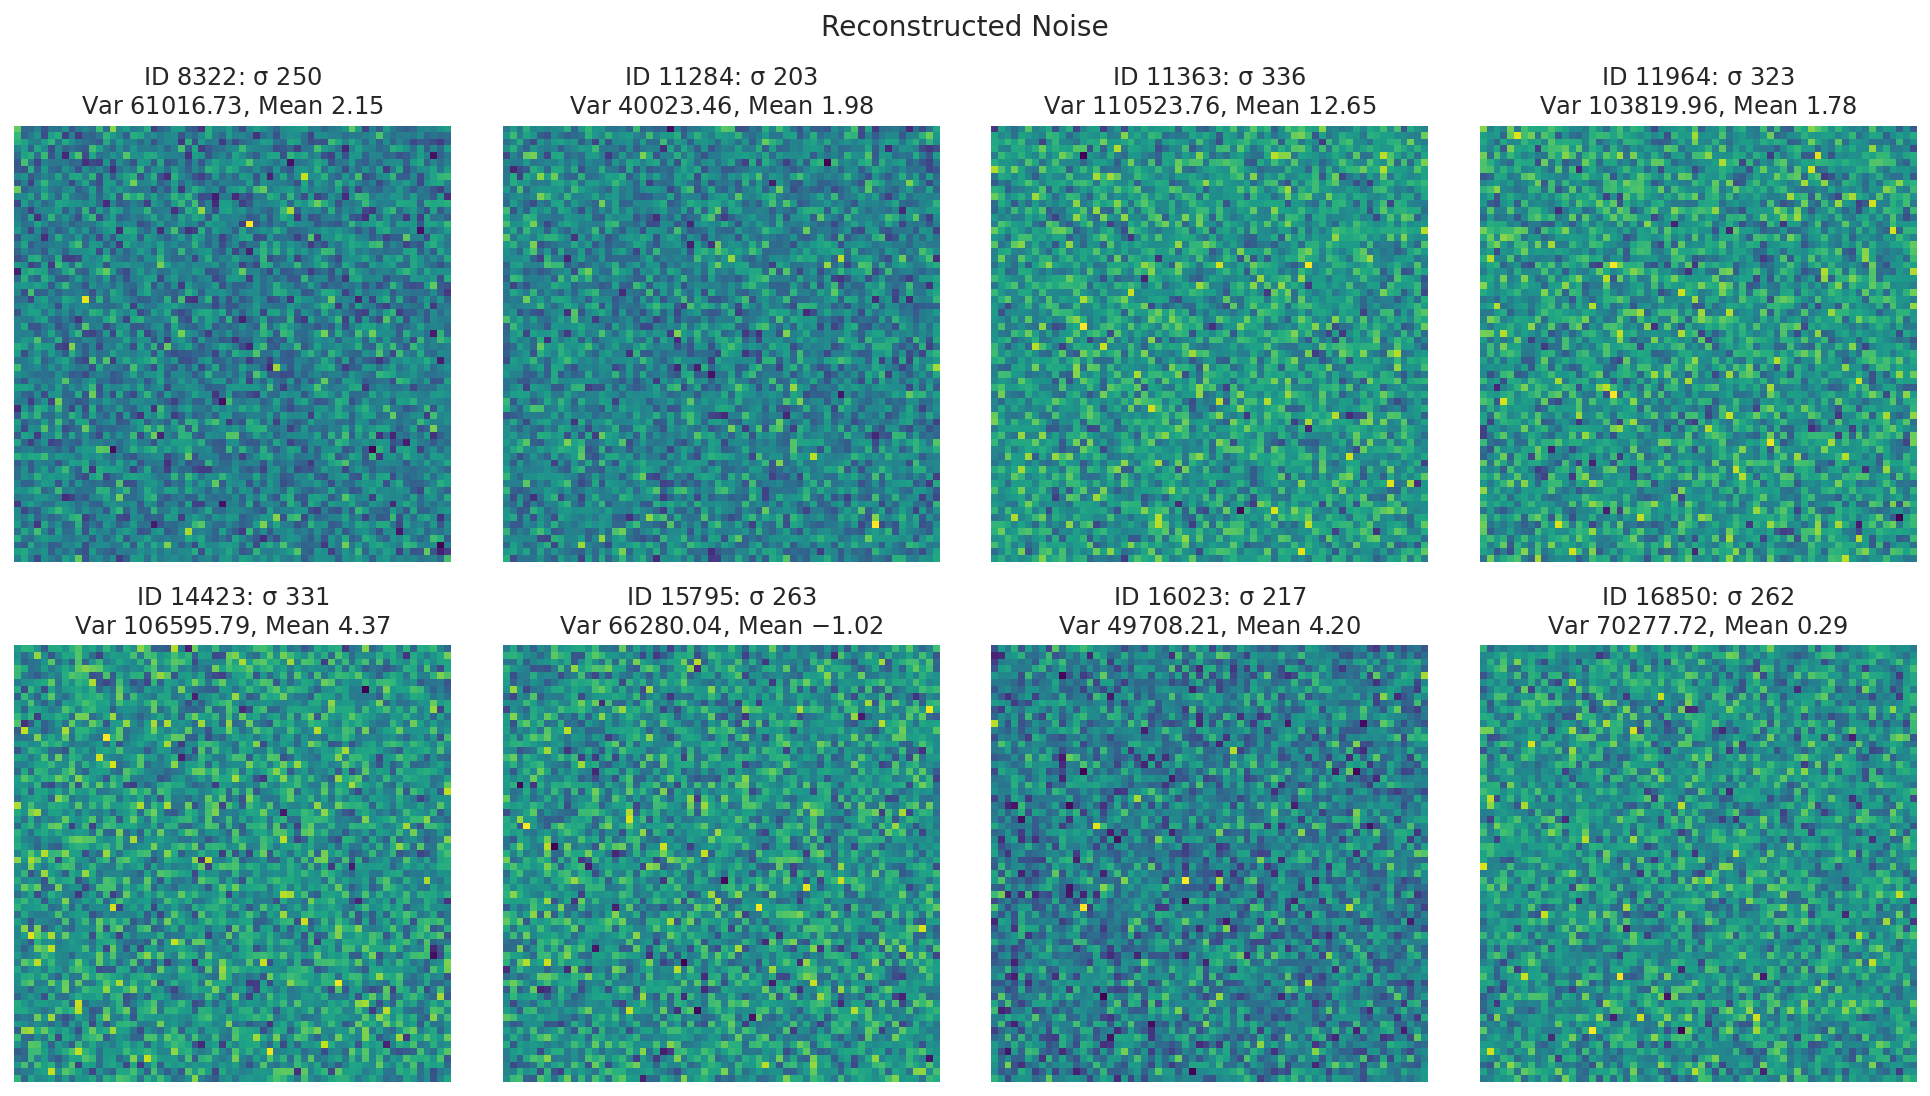

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(13.5, 7.5), constrained_layout=True)

title = """ID {}: σ ${sigma:.0f}$
Var ${var:.2f}$, Mean ${mean:.2f}$"""

for i, ax in zip(idx[-8:], axes.flat):
    img = -(image_withnoise[i] - image_nonoise[i])
    ax.imshow(img)
    ax.set_title(title.format(i, sigma=sigma[i], var=img.var(), mean=img.mean()))
    ax.axis("off")

fig.suptitle("Reconstructed Noise", fontsize=14);

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* The noise images are very random and do not seem to have any pattern
* One thing to note is that darker images have low Sigma i.e. less absolute level of noise

<div class='gc'> <b> Plot the mean image from all tables plus noise </b> </div>

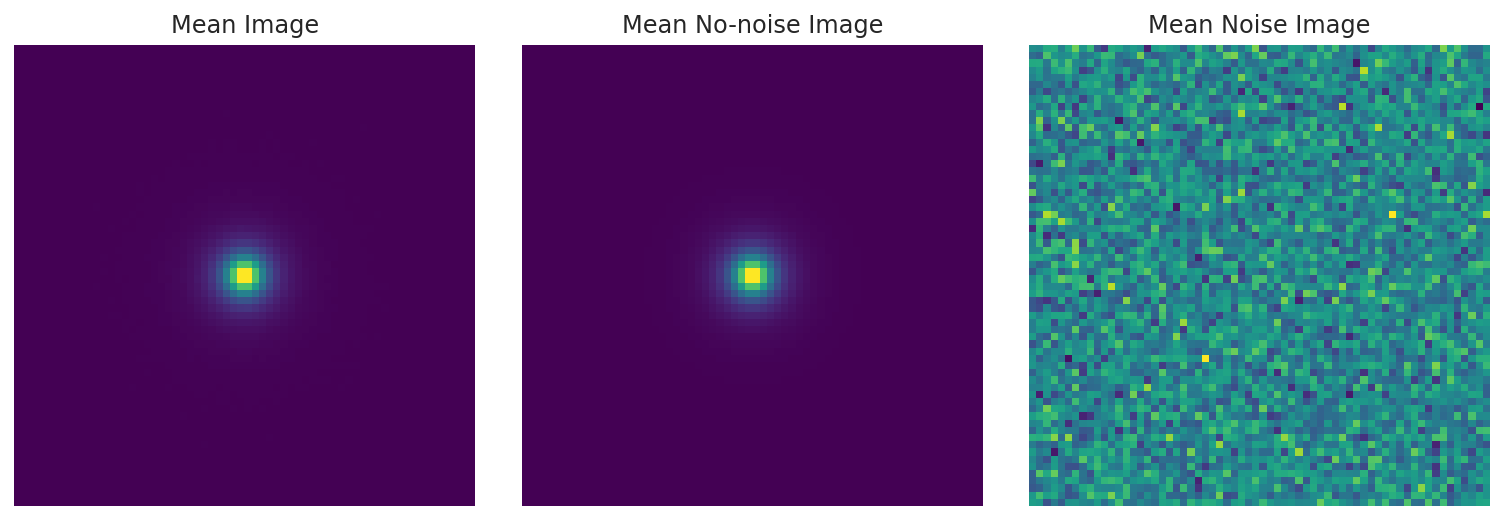

In [13]:
comparison = {
    "Mean Image": image.mean(axis=0),
    "Mean No-noise Image": image_nonoise.mean(axis=0),
    "Mean Noise Image": (image_withnoise - image_nonoise).mean(axis=0),
}

fig, axes = plt.subplots(1, 3, figsize=(10.5, 3.5), constrained_layout=True)
for (title, img), ax in zip(comparison.items(), axes):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* Mean image of all tables is exactly the same
* This highlights the fact that the mean noise in the images is $0$
* The Mean Noise is grainy: matplotlib enhances the differences that are representing noise by scaling them to the $0-1$ range

<div class='gc'> <b> Plot selected images from the Cat table </b> </div>

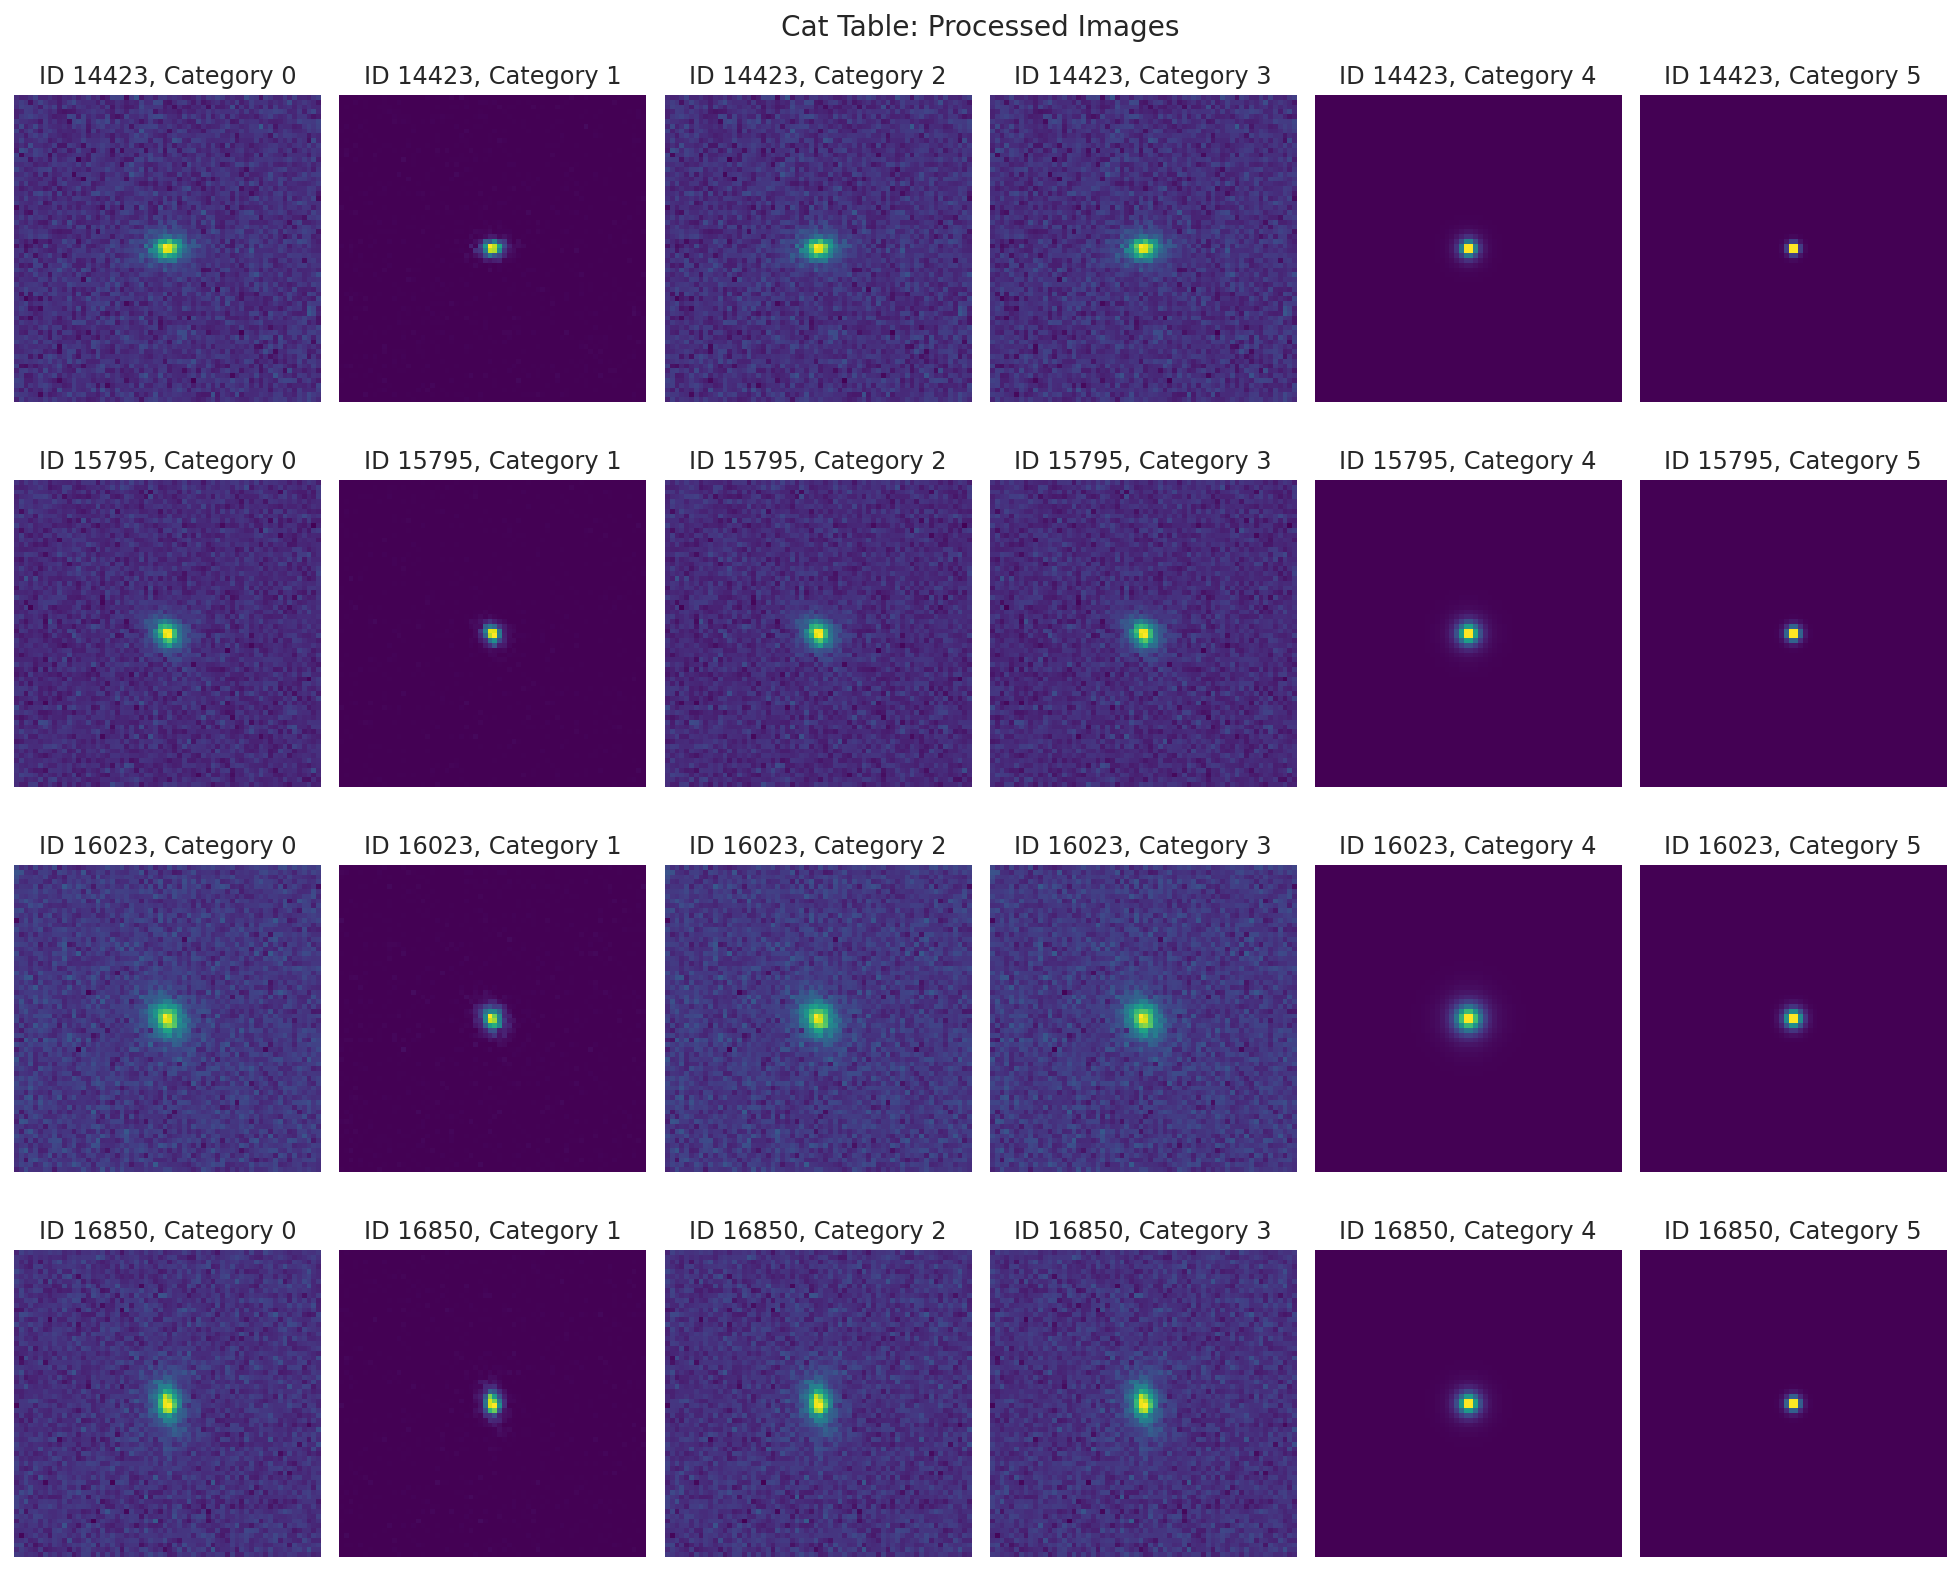

In [14]:
fig, ax = plt.subplots(4, 6, figsize=(13.5, 11), constrained_layout=True)

for i, image_id in enumerate(idx[-4:]):
    for j in range(6):
        ax[i, j].imshow(cat[image_id, j])
        ax[i, j].set_title(f"ID {image_id}, Category {j}")
        ax[i, j].axis("off")

fig.suptitle("Cat Table: Processed Images", fontsize=14);

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* Category 0 is the original image
* Category 2 and 3 look almost the same
* Category 1 looks like partial noise reduction whereas category 4 looks like complete noise reduction
* Category 5 seems to be getting rid of the halo around the image

### <div class='exercise'> <b> Step 5: Basic Visualization of the SNR, Sigma, and label data </b> </div>

<div class='gc'> <b> Plot the distributions of SNR and Sigma </b> </div>

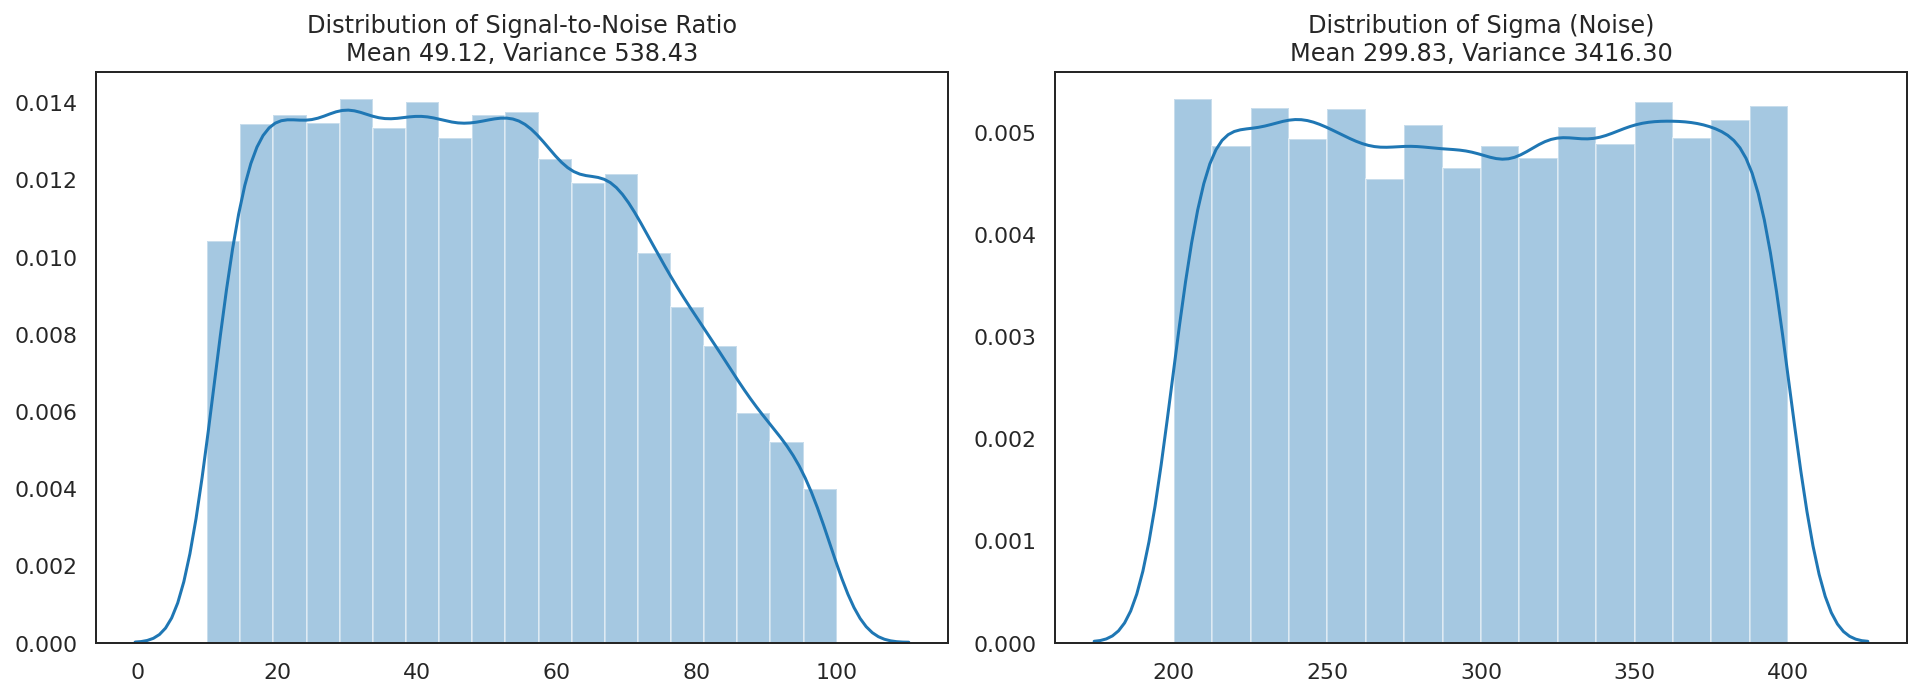

In [15]:
plt.figure(figsize=(13.5, 5), tight_layout=True)
plt.subplot(1, 2, 1)
sns.distplot(snr, bins="doane").set(
    title="Distribution of Signal-to-Noise Ratio\nMean {:0.2f}, Variance {:0.2f}".format(
        snr.mean(), snr.var()
    )
)
plt.subplot(1, 2, 2)
sns.distplot(sigma, bins="doane").set(
    title="Distribution of Sigma (Noise)\nMean {:0.2f}, Variance {:0.2f}".format(sigma.mean(), sigma.var())
);

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* Sigma i.e. the absolute level of noise is likely uniformly distributed across images
* Signal-to-Noise ratio is uniformly distributed for low SNR images; for high SRN images there is an inverse relationship, i.e. the number of images with high SNR goes down as SNR increases
    - In real-life data, usually, it is difficult to get high-quality data; as the quality increases the quantity of available data goes down

<div class='gc'> <b> Plot the distributions of label data </b> </div>

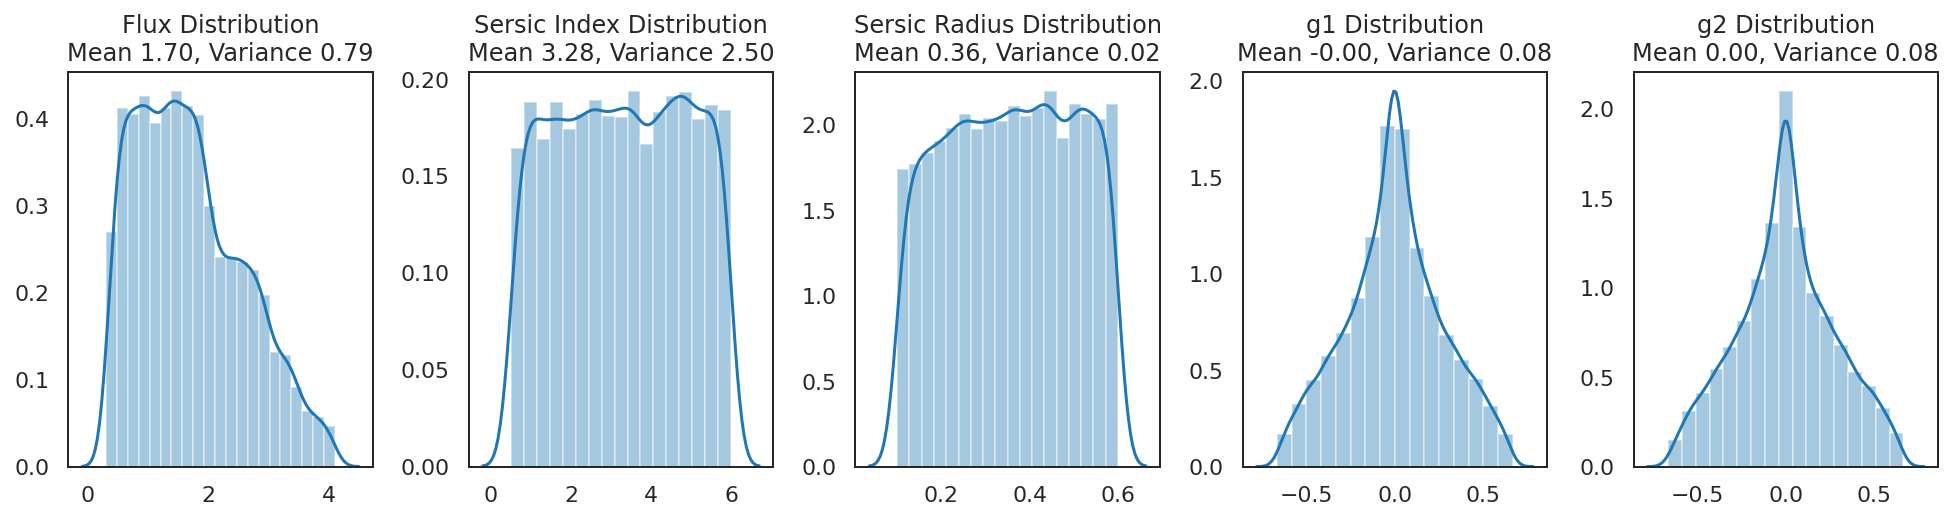

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(13.5, 3.5), constrained_layout=True)

for i in range(5):
    sns.distplot(label[:, i], bins="doane", ax=ax[i]).set(
        title="{} Distribution\nMean {:0.2f}, Variance {:0.2f}".format(
            labels.columns[i], label[:, i].mean(), label[:, i].var()
        )
    )

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* Flux likely follows the Poisson distribution
* Sersic Index and Sersic Radius are likely uniformly distributed
* g1 and g2 have the same distribution - it is not surprising given the mathematical relationship between them:
    
$$
\begin{aligned}
g_1 &= A \times \cos(2 \times Orientation) \\
g_2 &= A \times \sin(2 \times Orientation) \\
\end{aligned}
$$
    
$$
\text{The distribution is symmetric around zero which is the mean, the median, and the mode.}
$$

<div class='gc'> <b> Pair-plot visualization </b> </div>

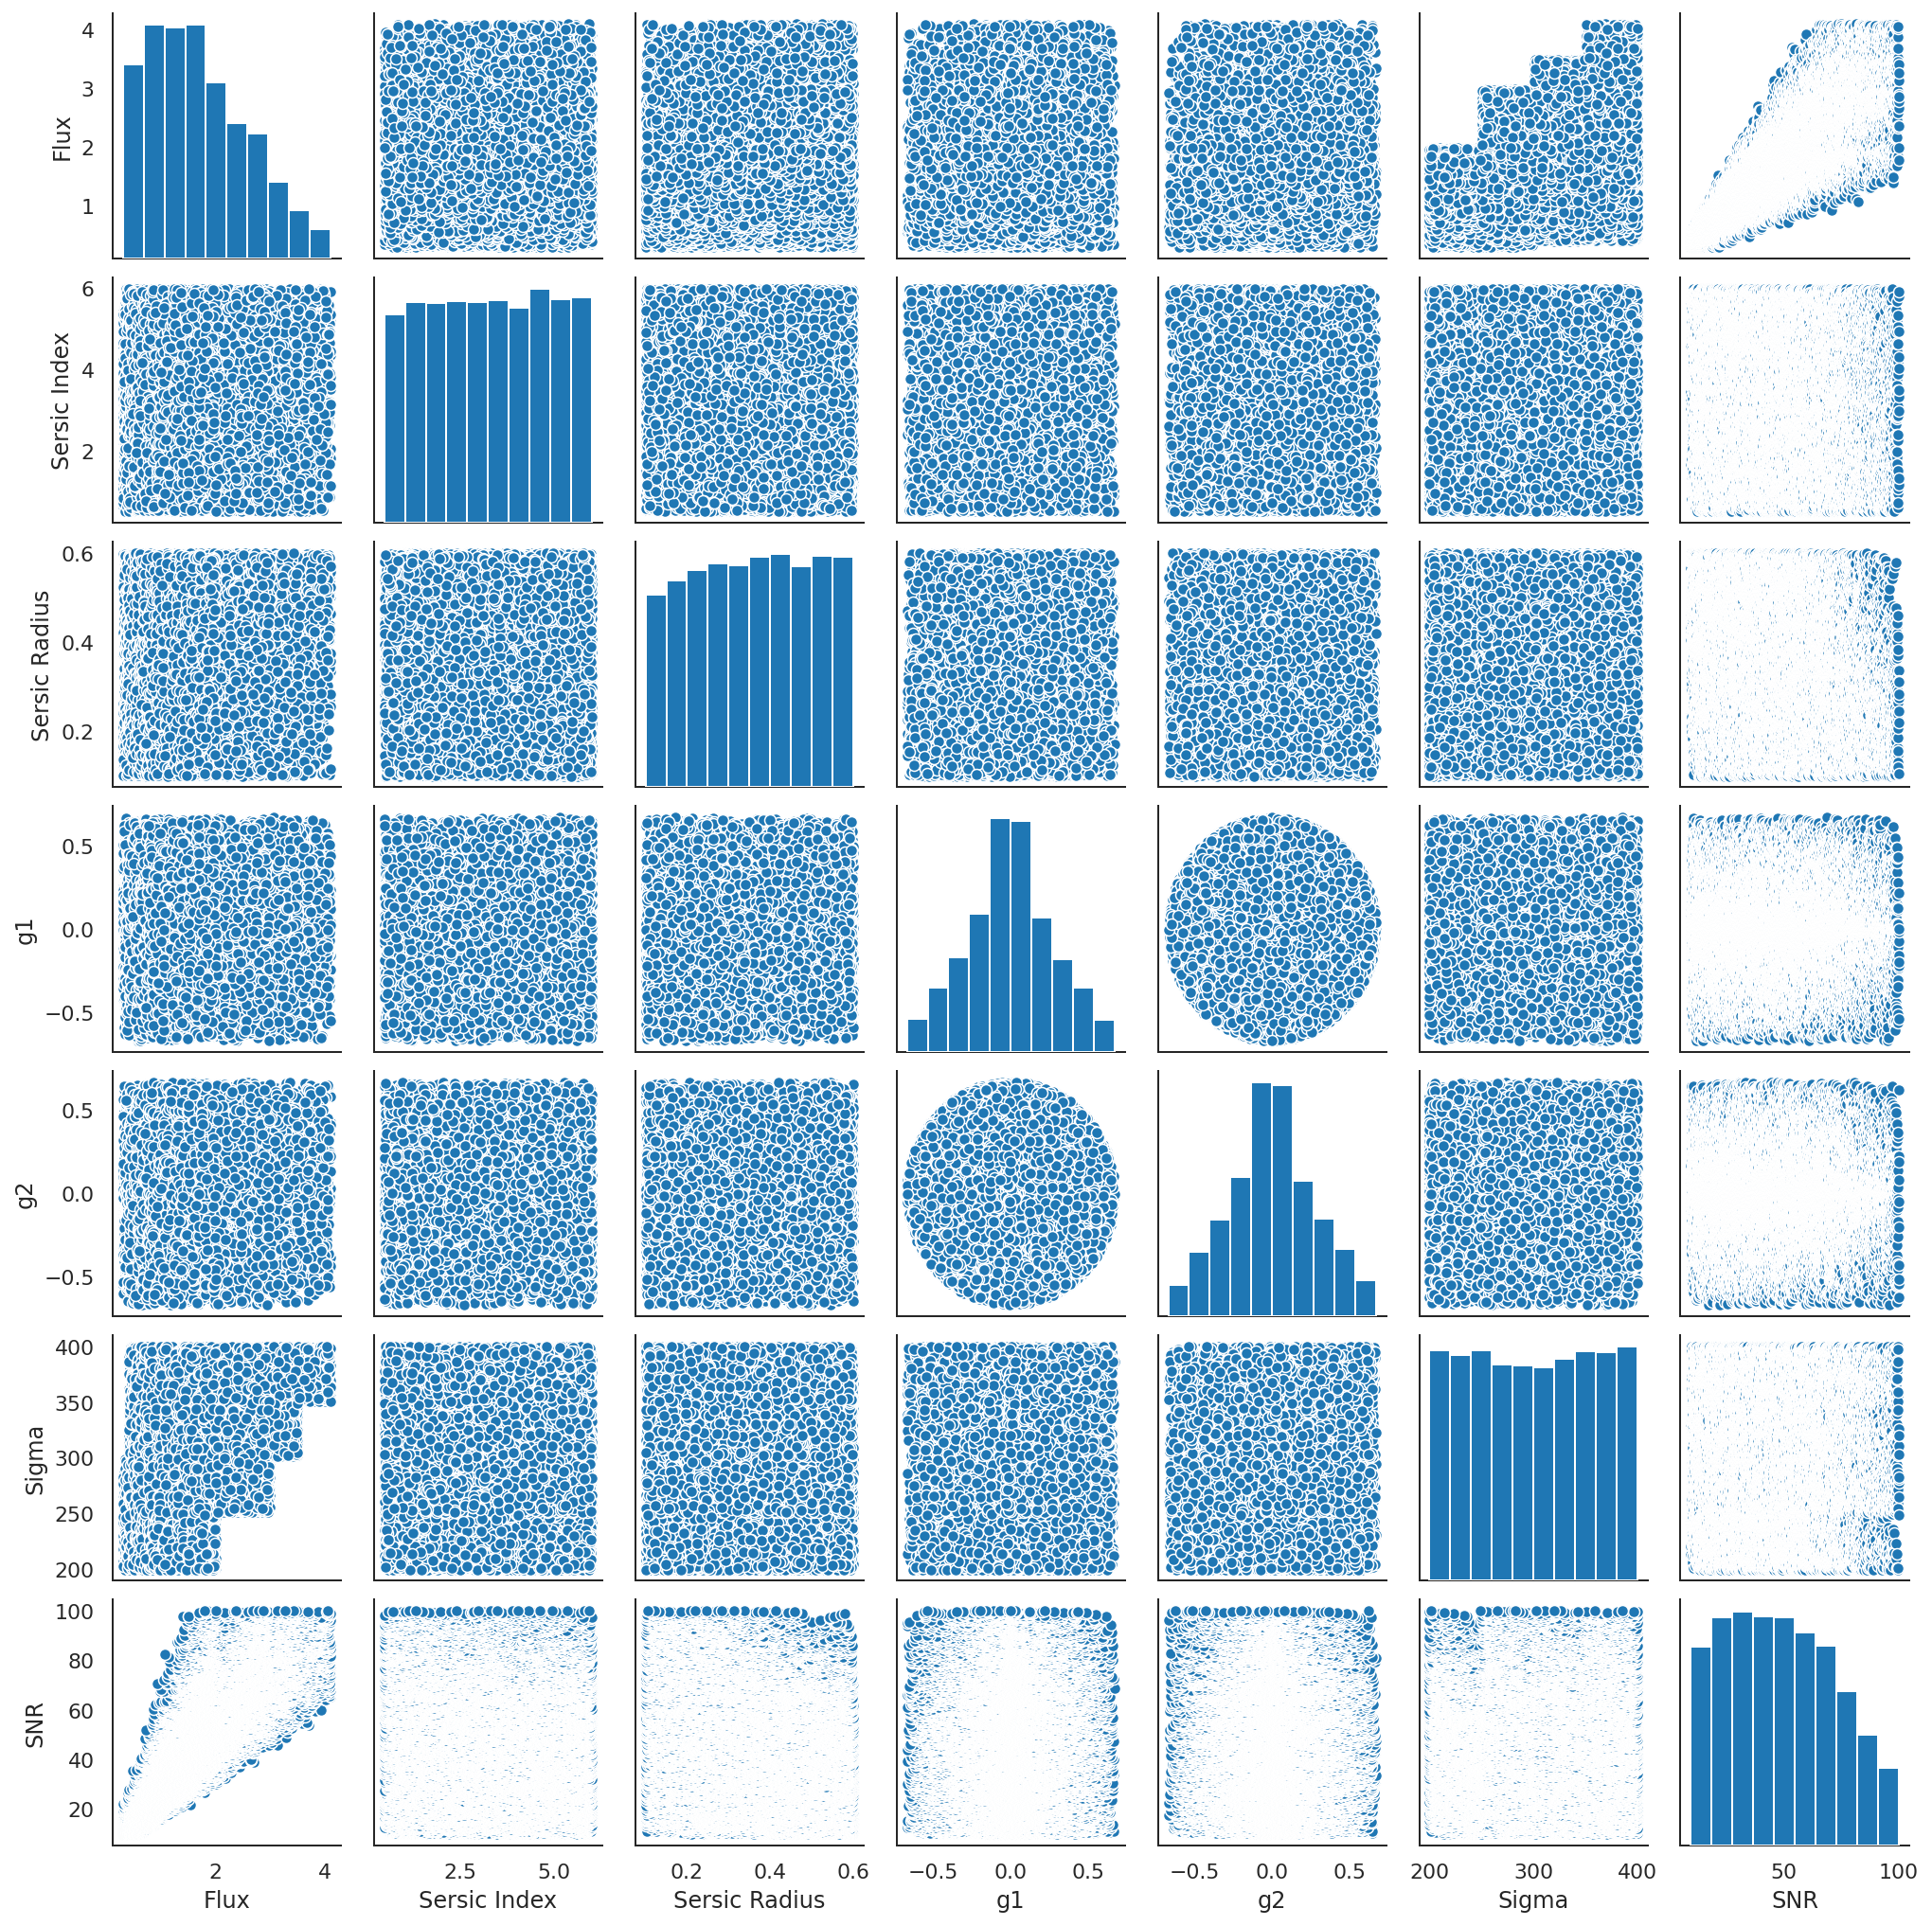

In [17]:
label_df = labels.copy()
label_df["Sigma"] = sigma
label_df["SNR"] = snr

sns.pairplot(label_df, height=2, aspect=1)
plt.show()

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* While not exactly linear, there is an increasing relationship between flux and SNR
    - Images of galaxies with high flux also have high SNR
    - This is not surprising as flux is a measure of the intensity of light; the brighter the light from the galaxy, the higher the SNR
* Interesting observation is that images of galaxies with high flux also have high sigma i.e. higher absolute noise level
    - There is a step up relationship there; it is a factor of how data was generated or generally true of real data as well
* The values of g1 and g2 fall inside a circular boundary — this is not surprising given the mathematical relationship between the two
* The pair plots of SNR needs further investigation to understand the bunching up of the points at the side
* The rest of the pair plots do not show any meaningful pattern

### <div class='exercise'> <b> Step 6: Image Data generation to understand the effect of different attributes  </b> </div>

<div class='gc'> <b> Interactive web app to parametrically simulate the galaxies </b> </div>

To see the link between the different attributes and the simulated images of galaxies please use our [interactive web app](https://measure-galaxies.herokuapp.com/). Under the hood, the application invokes `GalSim`, which was also used to generate the provided dataset.

---

<div class='gc'> <b> Function to generate galaxy image data and plot them </b> </div>

In [18]:
def generate_images(psf_re, bulge_re, bulge_n, A, gal_beta, noise, gal_flux):
    """
    
    Parameter random generations or supplied values
    
    psf_re:   PSF moffat scale radius in arcsec 
    bulge_re: sersic radius, unit arcsec
    bulge_n:  sersic index
    A: gal_q: ellipticity - b/a will ranges in (0.2,1) & A=1-q / 1+q
    gal_beta: orientation - radians 
    noise:    sigma proportional to inverse of SNR
    gal_flux: flux i.e. spectral intensity in 100K units
    
    """
    size = 1
    img_nonoise_ = np.zeros((size, 64, 64))

    image_size = 64  # n x n pixels
    pixel_scale = 0.23  # arcsec / pixel
    psf_beta = 2  # moffat parameter

    # q is ellipticity and beta is orientation.
    # You could directly predict q and beta but there would be a discontiniuty issue for beta.
    # A jump from 180 degree to 1 degree.
    # radial sampling for g1 and g2 -reduced shear -> ellipticiy and orientation
    # gal_q =b/a will ranges in (0.2,1) & A=1-q / 1+q
    gal_q = (1 - A) / (1 + A)
    g_1 = A * np.cos(2 * gal_beta)
    g_2 = A * np.sin(2 * gal_beta)

    gal_flux = 1e5 * gal_flux

    gal = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
    gal = gal.withFlux(gal_flux)
    gal = gal.shear(g1=g_1, g2=g_2)
    psf = galsim.Moffat(beta=psf_beta, flux=1.0, fwhm=psf_re)
    final = galsim.Convolve([psf, gal])
    image1 = galsim.ImageF(image_size, image_size, scale=pixel_scale)
    final.drawImage(image=image1)
    image_nonoise1 = copy.deepcopy(image1.array)

    # signal to noise ratio, after generating data, choose data with snr [10,100]
    snr1 = np.sqrt((image1.array ** 2).sum()) / noise

    image1.addNoise(galsim.PoissonNoise(sky_level=0.0))
    noisemap = np.random.normal(0, noise, 64 * 64)  # noise map for bkgr gaussian noise
    noisemap = noisemap.reshape((64, 64))

    # you can also use add noise to add gaussian noise by using 'image.addNoise(galsim.GaussianNoise(sigma=noise))'
    img_fv = image1.array + noisemap

    final_2 = psf
    image_2 = galsim.ImageF(image_size, image_size, scale=pixel_scale)
    final_2.drawImage(image=image_2)

    img_ = img_fv  # final noised image
    img_2_ = image_2.array  # psf
    return image_nonoise1, img_, img_2_


def plot_galaxies(
    psf_re=random.uniform(0.5, 1),
    bulge_re=random.uniform(0.1, 0.6),
    bulge_n=random.uniform(0.5, 6),
    A=random.uniform(0, 0.67),
    gal_beta=random.uniform(0, 3.14),
    noise=random.randint(200, 400),
    gal_flux=random.uniform(0.3, 4),
):

    image_nonoise1, img_, img_2_ = generate_images(psf_re, bulge_re, bulge_n, A, gal_beta, noise, gal_flux)

    fig = plt.figure(figsize=(9, 3.5), constrained_layout=True)
    ax = plt.subplot(1, 3, 1)
    plt.imshow(image_nonoise1)  # image without noise
    ax.set_title("Image Without Noise")
    ax.axis("off")
    ax = plt.subplot(1, 3, 2)
    plt.imshow(img_)  # final image
    ax.set_title("Final Image")
    ax.axis("off")
    ax = plt.subplot(1, 3, 3)
    plt.imshow(img_2_)  # psf
    ax.set_title("PSF")
    ax.axis("off")
    return fig

<div class='gc'> <b> Plots showing some key attribute changes </b> </div>

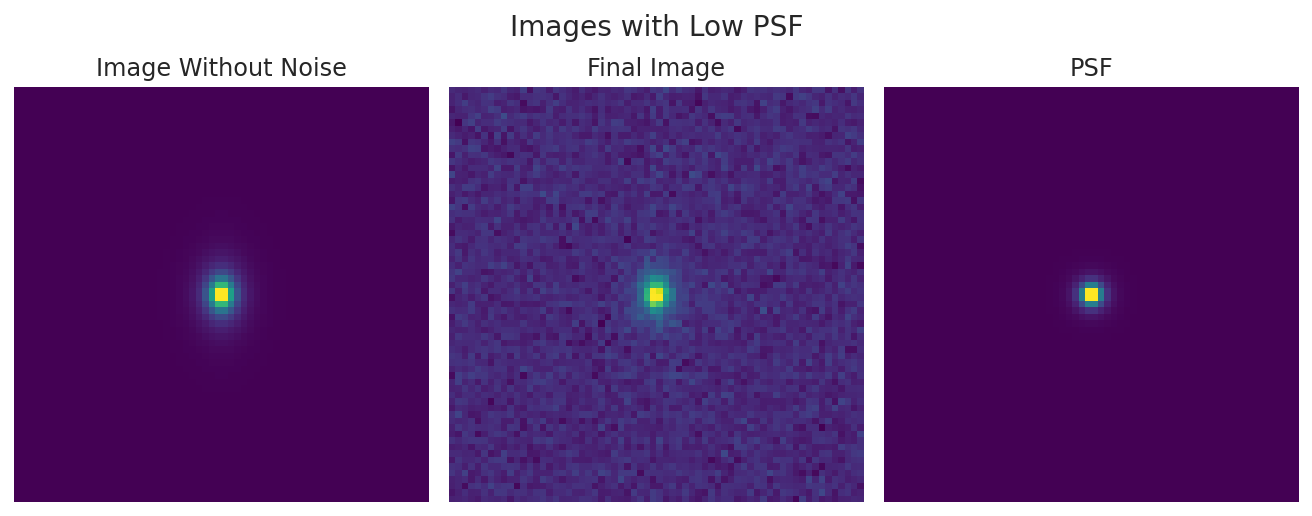

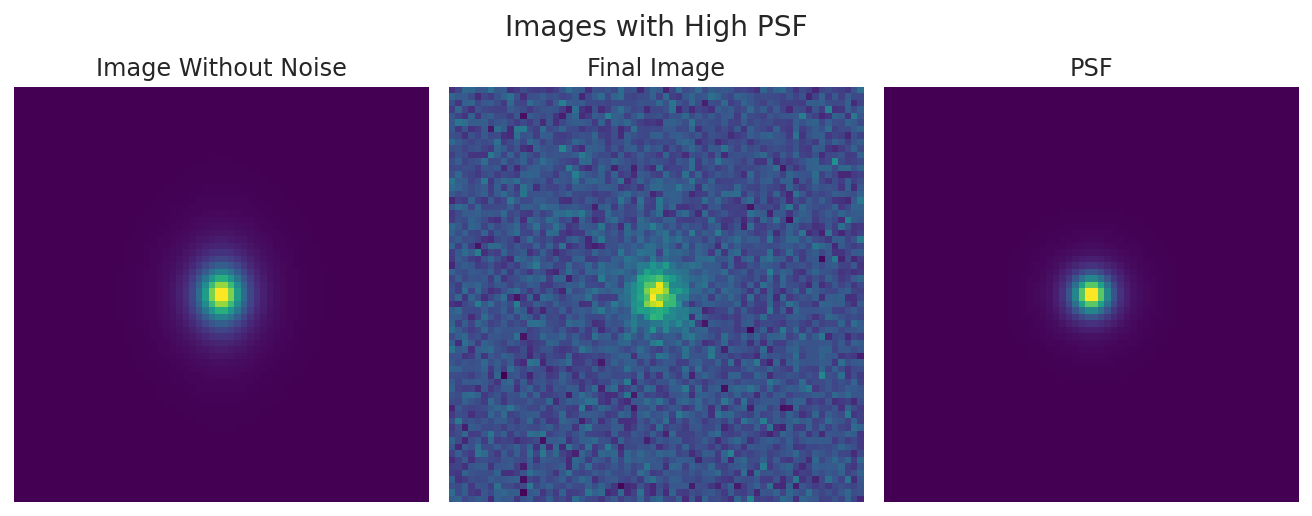

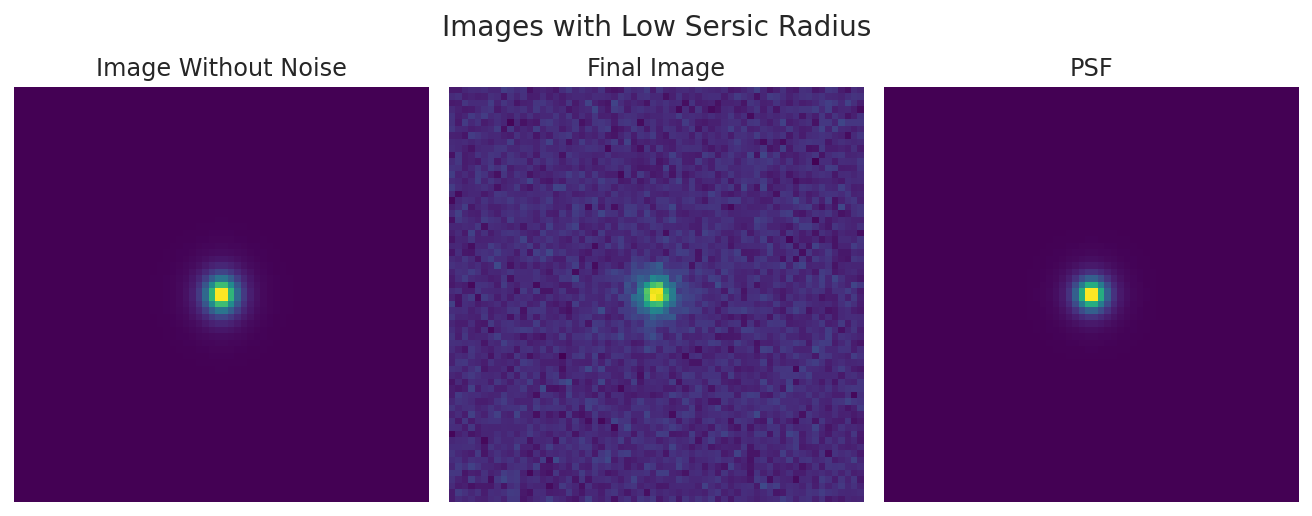

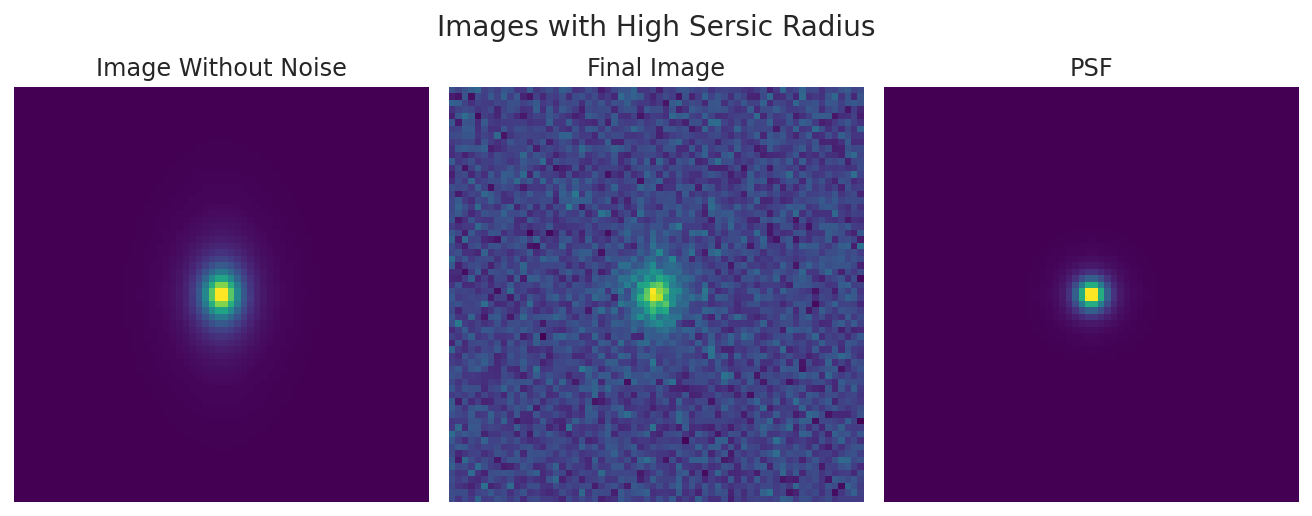

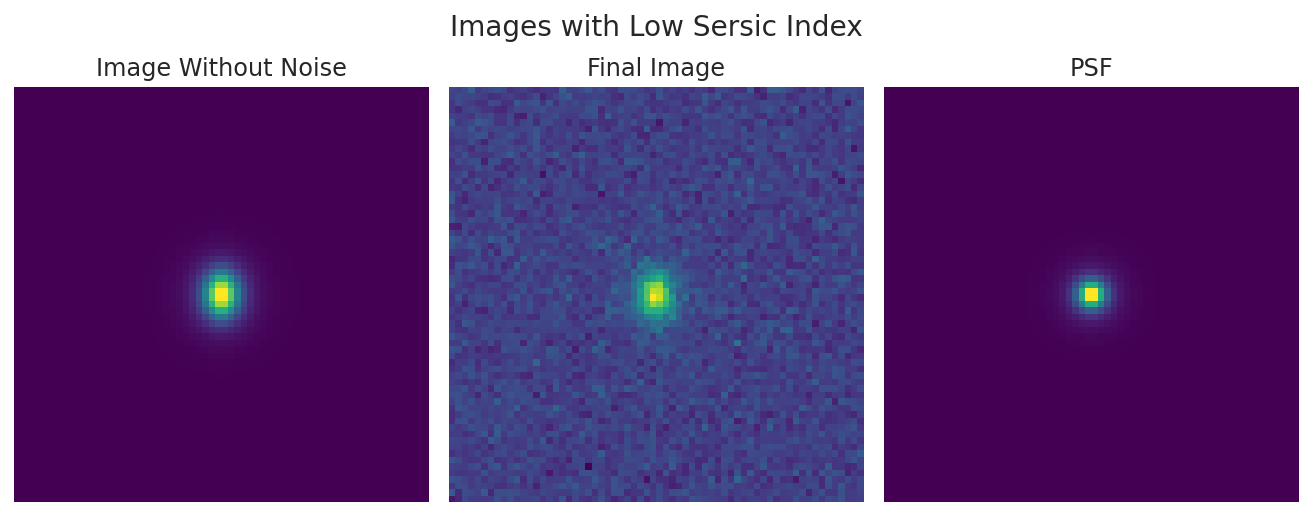

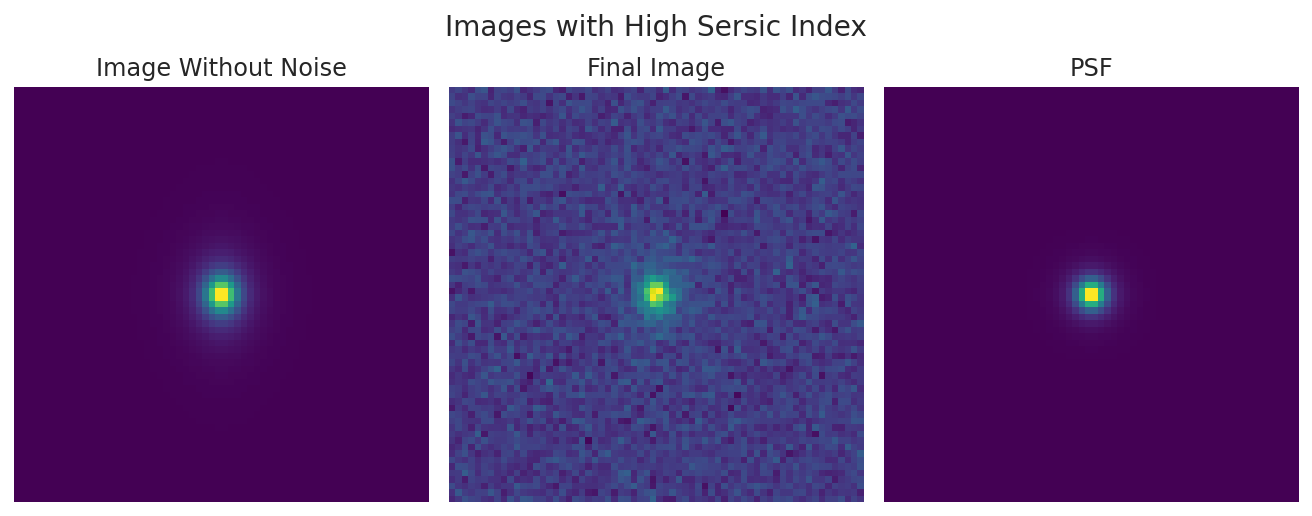

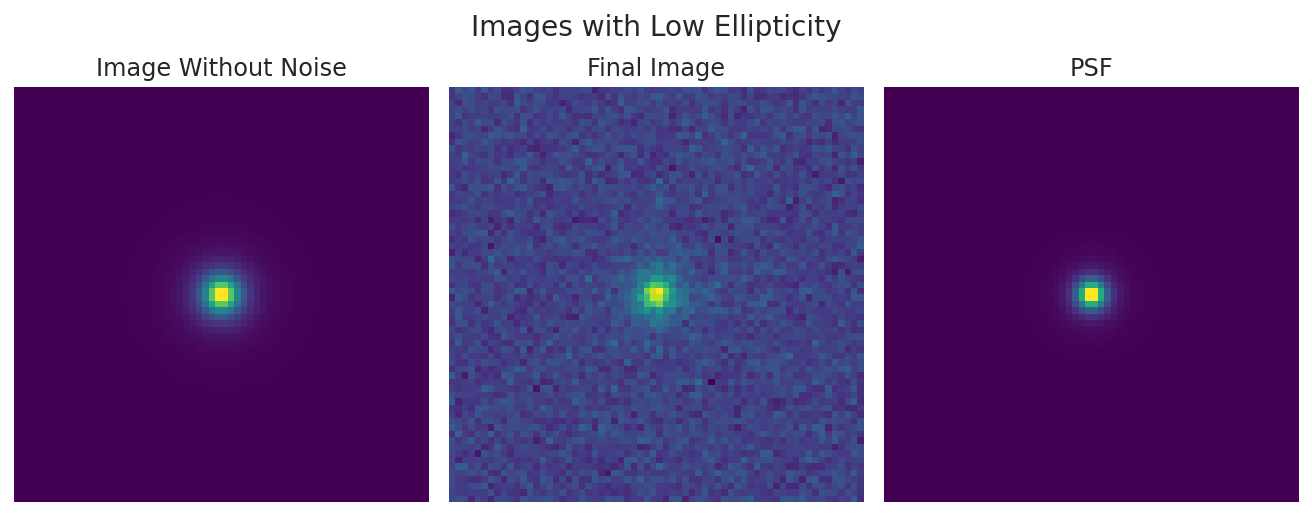

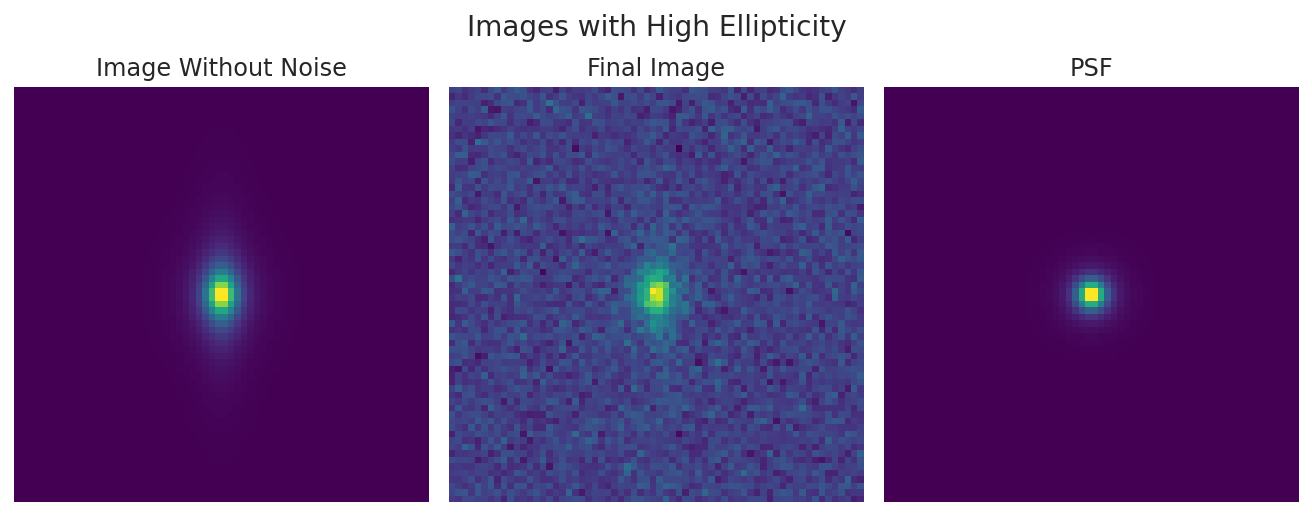

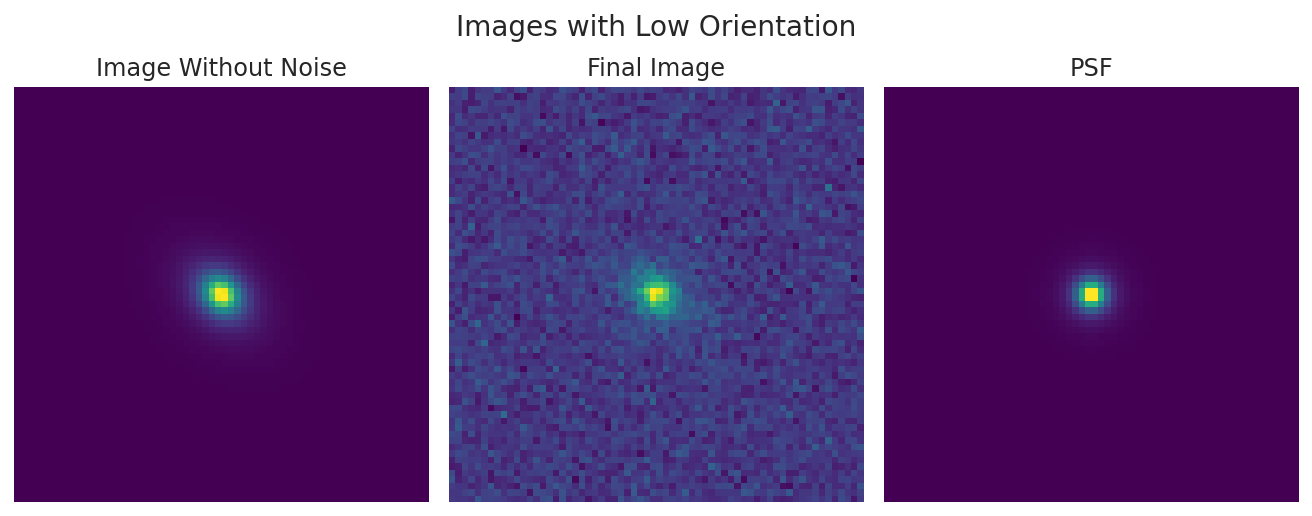

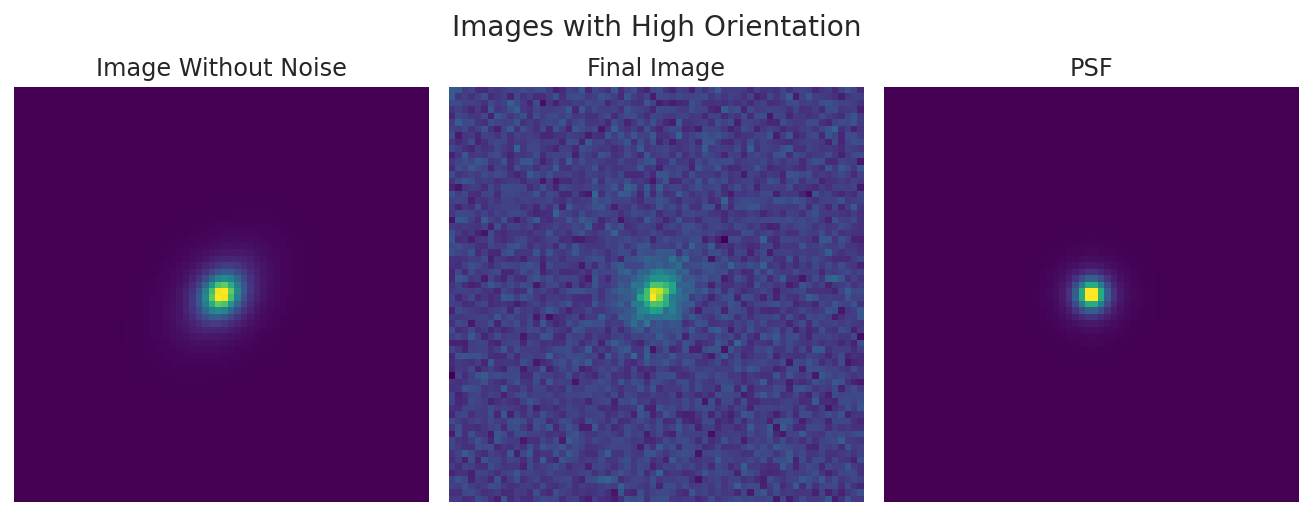

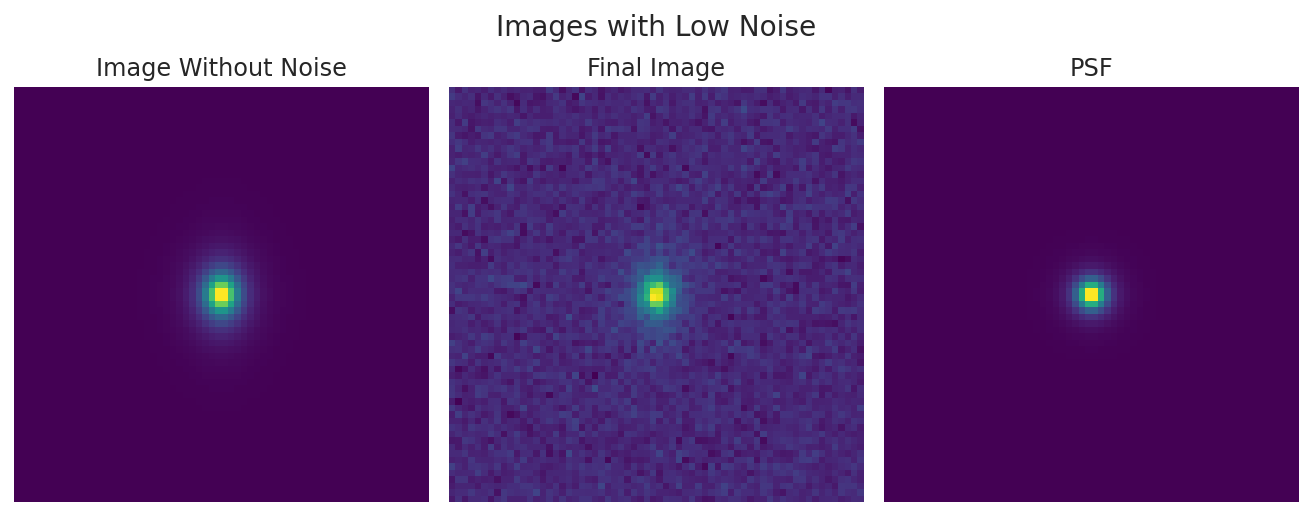

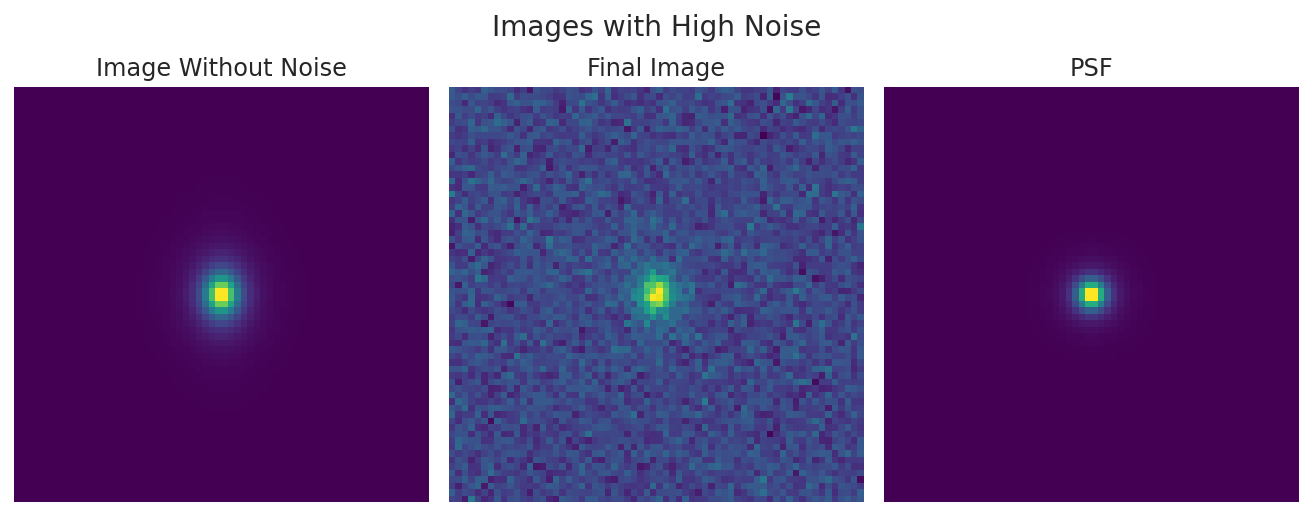

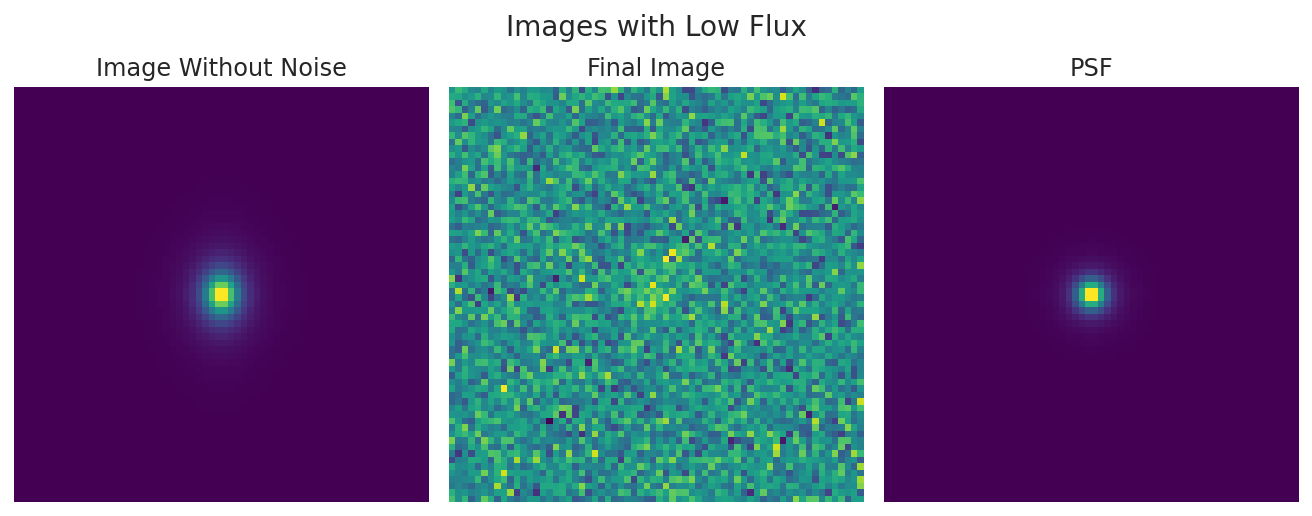

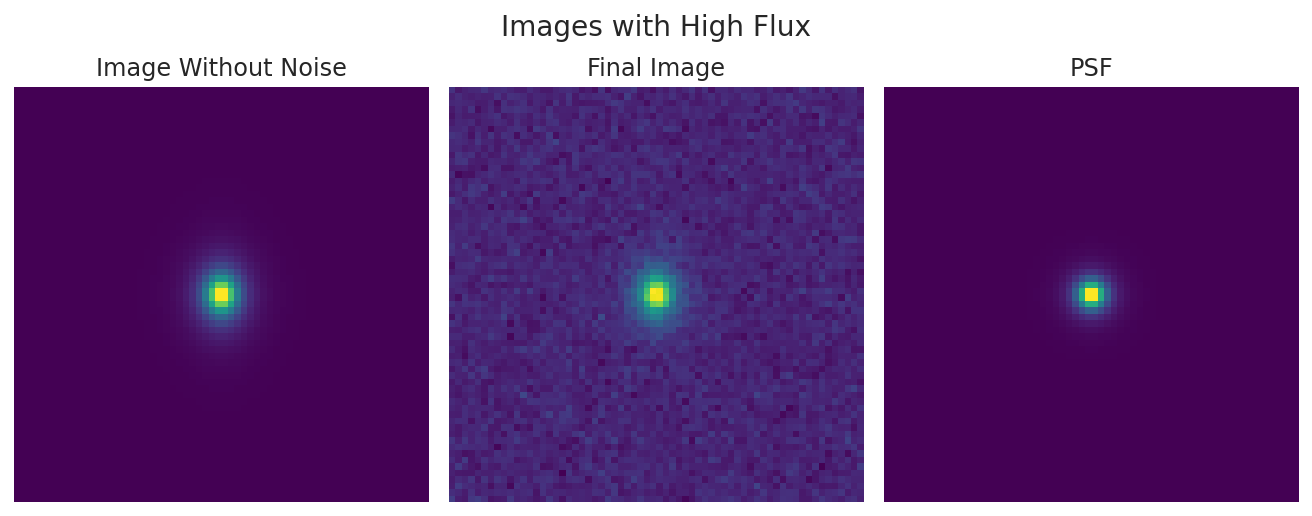

In [19]:
plot_df = {
    "Low PSF": [0.50, 0.35, 3.00, 0.34, 1.57, 300, 2.15],
    "High PSF": [1.00, 0.35, 3.00, 0.34, 1.57, 300, 2.15],
    "Low Sersic Radius": [0.75, 0.10, 3.00, 0.34, 1.57, 300, 2.15],
    "High Sersic Radius": [0.75, 0.60, 3.00, 0.34, 1.57, 300, 2.15],
    "Low Sersic Index": [0.75, 0.35, 0.50, 0.34, 1.57, 300, 2.15],
    "High Sersic Index": [0.75, 0.35, 6.00, 0.34, 1.57, 300, 2.15],
    "Low Ellipticity": [0.75, 0.35, 3.00, 0.00, 1.57, 300, 2.15],
    "High Ellipticity": [0.75, 0.35, 3.00, 0.67, 1.57, 300, 2.15],
    "Low Orientation": [0.75, 0.35, 3.00, 0.34, 0.78, 300, 2.15],
    "High Orientation": [0.75, 0.35, 3.00, 0.34, 2.29, 300, 2.15],
    "Low Noise": [0.75, 0.35, 3.00, 0.34, 1.57, 200, 2.15],
    "High Noise": [0.75, 0.35, 3.00, 0.34, 1.57, 400, 2.15],
    "Low Flux": [0.75, 0.35, 3.00, 0.34, 1.57, 300, 0.30],
    "High Flux": [0.75, 0.35, 3.00, 0.34, 1.57, 300, 4.00],
}

for key in plot_df.keys():
    psf_re, bulge_re, bulge_n, A, gal_beta, noise, gal_flux = plot_df[key]
    plot_galaxies(psf_re, bulge_re, bulge_n, A, gal_beta, noise, gal_flux)
    plt.gcf().suptitle(f"Images with {key}", fontsize=14)

<div style="border: 3px solid #800080; padding: 10px"> 
    
***Observations:***
* Low PSF means the light is concentrated and its easier to spot the galaxy; as the PSF rises the light is more spread out and becomes harder to distinguish from the background
* Sersic Radius works in a similar manner to PSF; low Sersic Radius means concentrated light and a galaxy that is easier to distinguish from the background noise
* Sersic Index gives the intensity of the galaxy; the higher the Sersic Index the more intense the light from the galaxy and easier it is to spot it
* Ellipticity describes the shape of the galaxy i.e. spherical vs elliptical
* Orientation describes the angles at which the galaxy is oriented in the image
* Flux describes the brightness of the galaxy - it is easier to spot the shape and location of a galaxy with high flux
* As the noise content of the image increases, the more blurry the galaxy's shape becomes

## <div class="theme"> Summary </div> 

<div style="border: 3px solid #800080; padding: 10px"> 
    
### ***Shape and Brightness of a Galaxy***

    
1. After explore the component of this dataset, we gained basic understanding of each dataset by visualize sample images and exam their statistical distributions:
    
This dataset shows us a typical example of a galaxy image dataset,with the common physical parameters that characterize the galaxy (flux, sersic index, sersic radius, g1, g2). Each parameters represents a specific characteristics of the galaxy. For example,we have learned that g1 and g2 are reduced shear, reparametrization of the ellipticity and orientation. In the future, we will use these parameters to categorize galaxies.

    
2. In line # 24 and #25, we ploted the distribution of each parameter, and the paired plots of parameters to observe possible correlations between parameters. Based on our observation, in this sample data, each parameter follows a specific distribution:
 - Flux likely follows poisson distribution
 - Sersic Index and Sersic Radius are likely uniformly distributed
 - g1 and g2 have the same guassian-like distribution


3. In order to stimulate more straightforward understanding of the impact of each parameter, we created an interactive widget to simulate different attributes. This widget shows the effect of different attributes on images: by tweaking each parameters, we can change the presence of the resulted images, and therefore possibly change the categorization of the resulted images.

    
4. The dataset also contains a typical imaging preprocessing result (cat). We sampled some images from each category and made some assumptions about the preprocessing approaches. Our understanding about each category is visualized/explained in line #22.
In the future study we will build our own image preprocessing categories before building NN models.

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">  End of Exploratory Data Analysis 
